In [1]:
import json
from math import log2, pi
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import qiskit.result
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from scipy.spatial import distance
from tqdm import tqdm

## Circuit for Hamming distance calculation

In [2]:
def hamdist_circuit(n_data_qubits, n_auxilia_qubits, lite=False):
    """Quantum circuit for  Hamming distance calculation"""
    qrx = QuantumRegister(n_data_qubits, "x")
    qry = QuantumRegister(n_data_qubits, "y")
    qra = QuantumRegister(n_auxilia_qubits, "a")
    circ = QuantumCircuit(qrx, qry, qra, name="Hamming distance")

    # Ecncoding
    circ.cx(qry, qrx)

    # Extraction
    circ.barrier()
    if qra.size == 1:
        circ.h(qra)
        circ.crz(pi / n_data_qubits, qrx, qra)
        circ.h(qra)

    elif qra.size > 1 and qrx.size == 4:
        circ.h(qra[0])
        circ.crz(pi / n_data_qubits, qrx[: n_data_qubits // 2], qra[0])
        for i in range(qra.size - 1):
            circ.swap(qra[i + 1], qra[i])
        circ.crz(pi / n_data_qubits, qrx[n_data_qubits // 2 :], qra[-1])
        circ.h(qra[-1])

    elif qra.size > 1 and qrx.size == 5:
        circ.h(qra[0])
        circ.crz(pi / qrx.size, qrx[: qrx.size // 2], qra[0])
        for i in range(qra.size // 2):
            circ.swap(qra[i + 1], qra[i])
        circ.crz(pi / qrx.size, qrx[qrx.size // 2], qra[qra.size // 2])
        for i in range(qra.size // 2, qra.size - 1):
            circ.swap(qra[i + 1], qra[i])
        circ.crz(pi / qrx.size, qrx[qrx.size // 2 + 1 :], qra[-1])
        circ.h(qra[-1])

    elif qra.size > 1 and qrx.size == 8:
        circ.h(qra[0])
        circ.crz(pi / qrx.size, qrx[:2], qra[0])

        for j in range(4):
            i_ancilla = 2 * j
            for i in range(2):
                circ.swap(qra[i_ancilla + i + 1], qra[i_ancilla + i])
            circ.crz(pi / qrx.size, qrx[j + 2], qra[i_ancilla + 2])

        for i in range(2):
            circ.swap(qra[qra.size - 2 + i], qra[qra.size - 3 + i])
        circ.crz(pi / qrx.size, qrx[qrx.size - 3 :], qra[-1])
        circ.h(qra[-1])
    else:
        raise NotImplementedError(f"to many ancilas: {n_auxilia_qubits}")

    # Decoding
    circ.barrier()
    if not lite:
        circ.cx(qry, qrx)

    return circ

### Example with 3 data qubits and single auxilia qubits

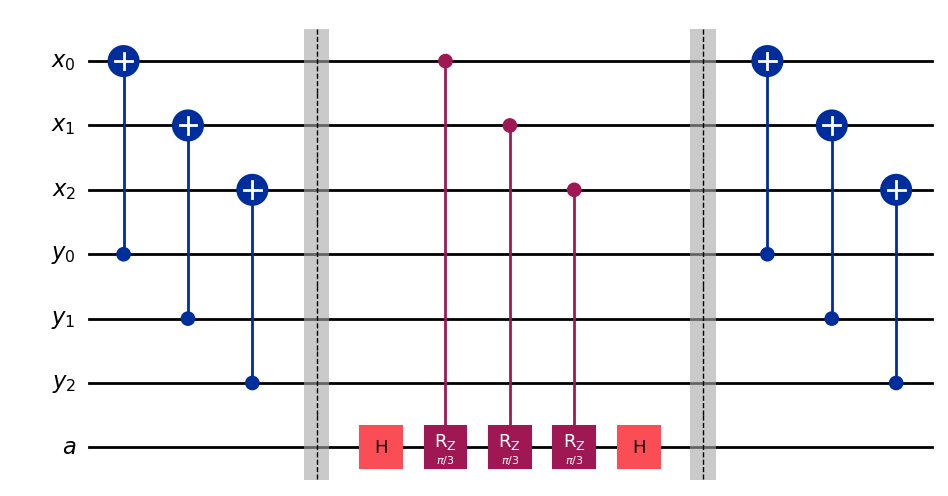

In [3]:
hamdist_circuit(3, 1, False).draw(output="mpl")

**Decomposed**

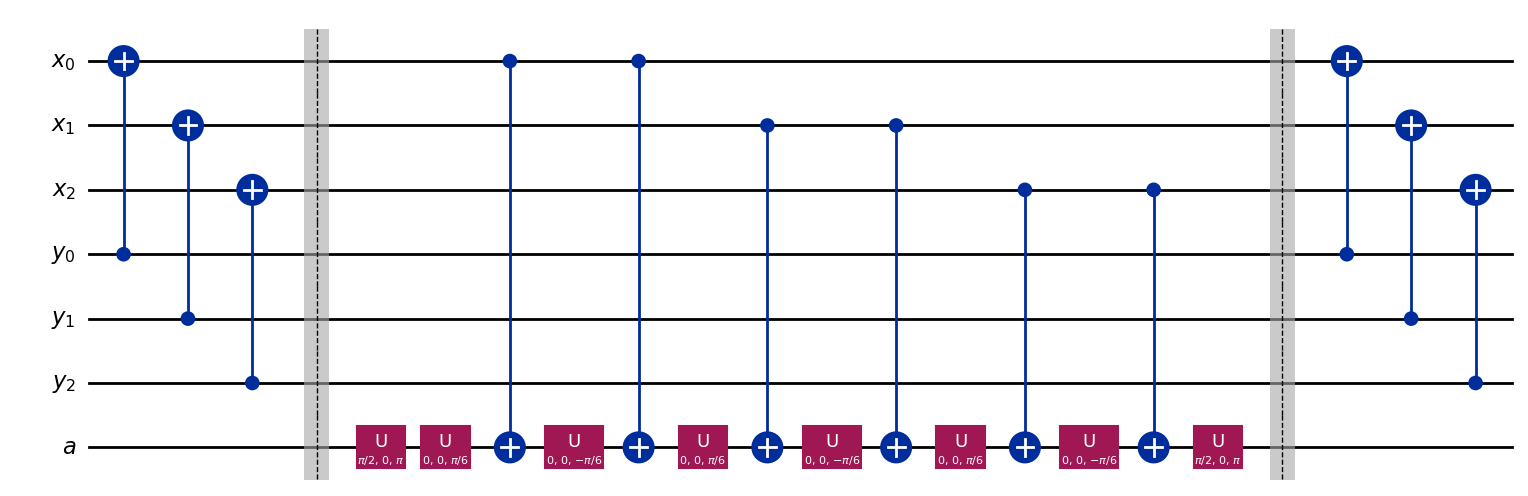

In [4]:
hamdist_circuit(3, 1, False).decompose(reps=6).draw(output="mpl")

#### Figure of circuit for paper

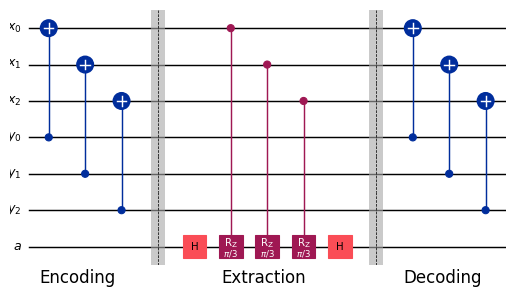

In [5]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 1)

style = {
    "fontsize": 14,
    "subfontsize": 12,
    "backgroundcolor": "white",
    "margin": [1.3, 0, 0, 0],
}

hamdist_circuit(3, 1, False).draw(ax=ax, style=style, output="mpl")

ax.text(-0.5, -7, "Encoding", fontsize=12)
ax.text(4.5, -7, "Extraction", fontsize=12)
ax.text(9.5, -7, "Decoding", fontsize=12)

fig.set_facecolor("white")
fig.savefig("hd-circuit-n3a1.pdf", bbox_inches="tight")

### Example with 4 data qubits and 3 auxilia qubits

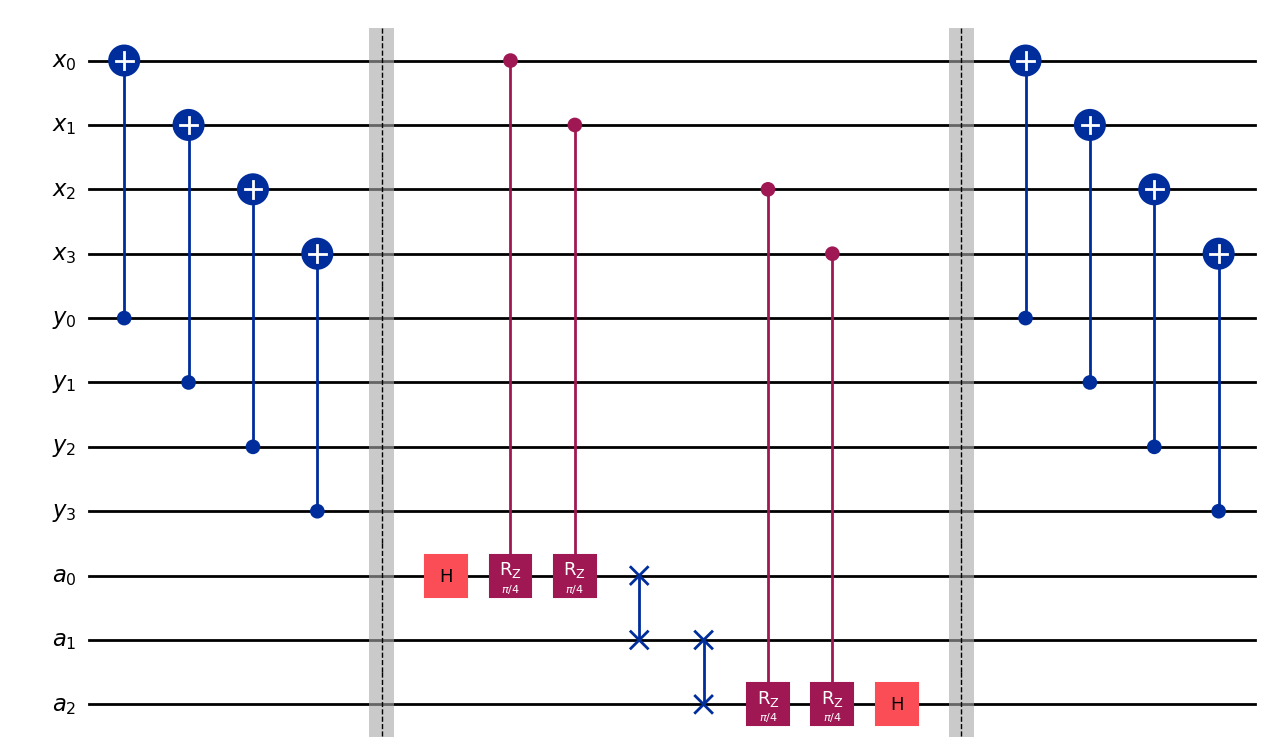

In [6]:
hamdist_circuit(4, 3, False).draw(output="mpl")

### Example with 5 data qubits and 5 auxilia qubits

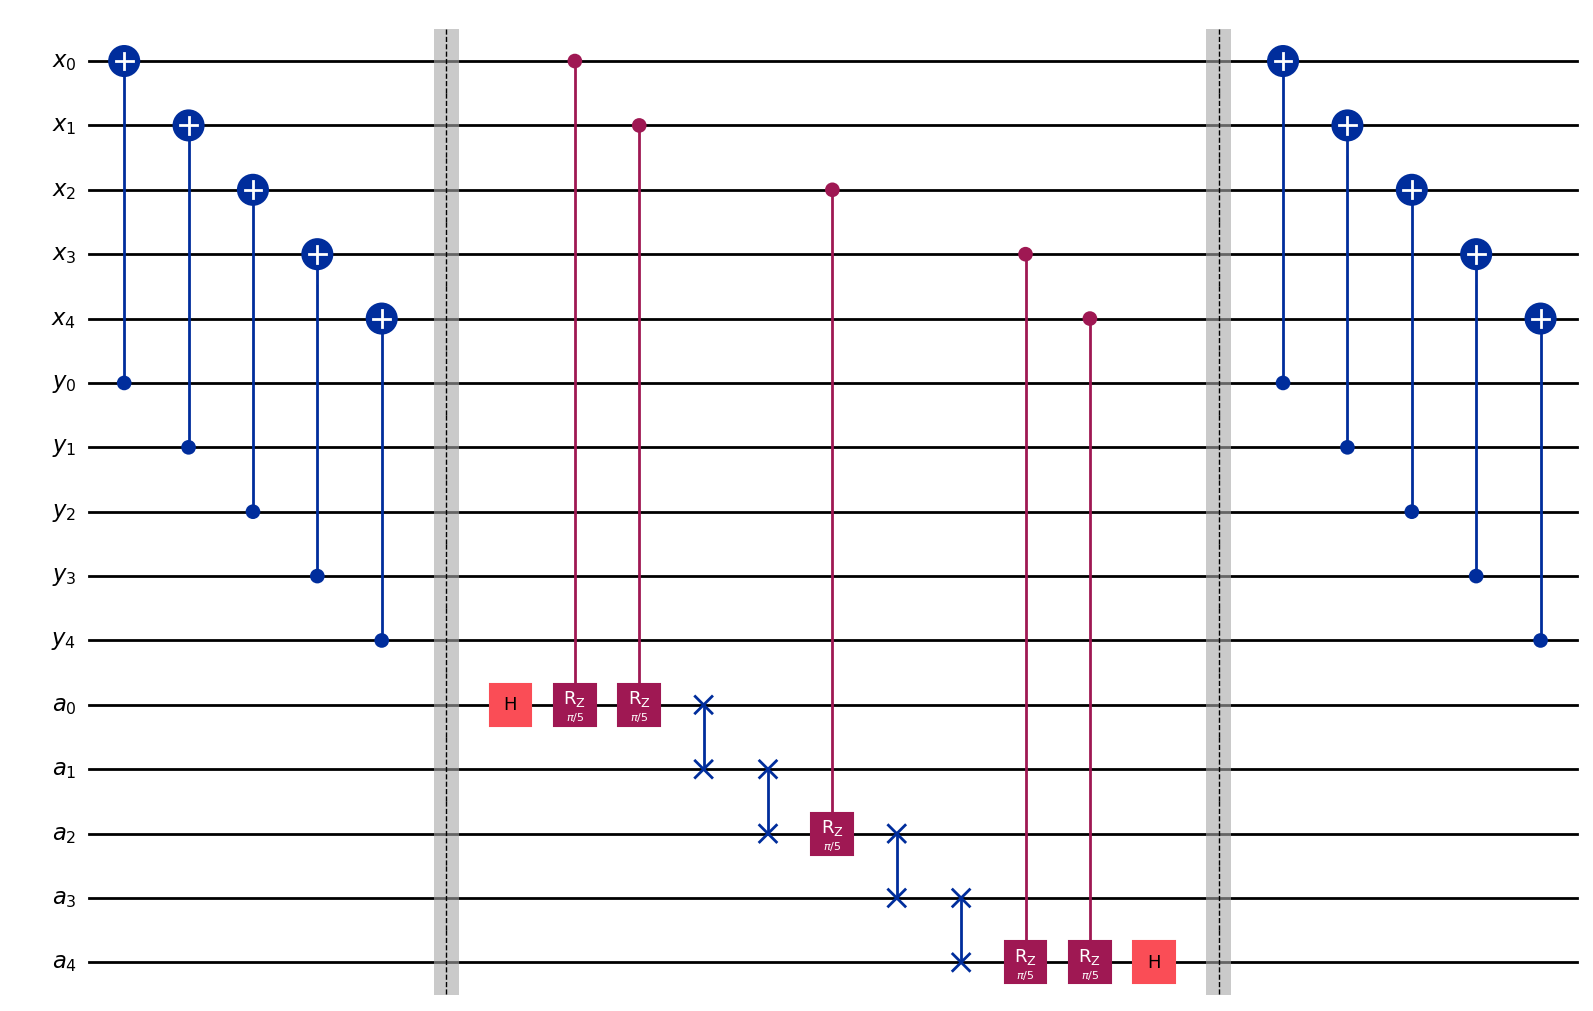

In [7]:
hamdist_circuit(5, 5, False).draw(output="mpl")

#### Figure of circuit for paper

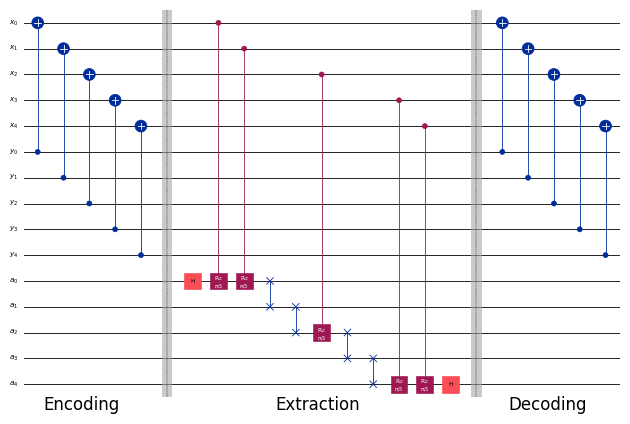

In [8]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 1)

style = {
    "fontsize": 14,
    "subfontsize": 12,
    "backgroundcolor": "white",
    "margin": [1.3, 0, 0, 0],
}

hamdist_circuit(5, 5, False).draw(ax=ax, style=style, output="mpl")

ax.text(0, -15, "Encoding", fontsize=12)
ax.text(9, -15, "Extraction", fontsize=12)
ax.text(18, -15, "Decoding", fontsize=12)

fig.set_facecolor("white")
fig.tight_layout()
fig.savefig(f"hd-circuit-n5a5.pdf", bbox_inches="tight")

### Example with 8 data qubits and 11 auxilia qubits

In [9]:
hamdist_circuit(8, 11, False).draw(fold=-1)

┌───┐                                    ░                                                                                                                                             ░ ┌───┐                                   
 x_0: ┤ X ├────────────────────────────────────░───────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤ X ├───────────────────────────────────
      └─┬─┘┌───┐                               ░           │                                                                                                                                 ░ └─┬─┘┌───┐                              
 x_1: ──┼──┤ X ├───────────────────────────────░───────────┼──────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───┼──┤ X ├──────────────────────────────
        │  └─┬─┘┌───┐                          ░           │          │                                                                                                                      ░   │  └─┬─┘┌───┐                         
 x_2: ──┼────┼──┤ X ├──────────────────────────░───────────┼──────────┼────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────░───┼────┼──┤ X ├─────────────────────────
        │    │  └─┬─┘┌───┐                     ░           │          │                │                                                                                                     ░   │    │  └─┬─┘┌───┐                    
 x_3: ──┼────┼────┼──┤ X ├─────────────────────░───────────┼──────────┼────────────────┼────────────────■────────────────────────────────────────────────────────────────────────────────────░───┼────┼────┼──┤ X ├────────────────────
        │    │    │  └─┬─┘┌───┐                ░           │          │                │                │                                                                                    ░   │    │    │  └─┬─┘┌───┐               
 x_4: ──┼────┼────┼────┼──┤ X ├────────────────░───────────┼──────────┼────────────────┼────────────────┼────────────────■───────────────────────────────────────────────────────────────────░───┼────┼────┼────┼──┤ X ├───────────────
        │    │    │    │  └─┬─┘┌───┐           ░           │          │                │                │                │                                                                   ░   │    │    │    │  └─┬─┘┌───┐          
 x_5: ──┼────┼────┼────┼────┼──┤ X ├───────────░───────────┼──────────┼────────────────┼────────────────┼────────────────┼────────────────■────────────────■─────────────────────────────────░───┼────┼────┼────┼────┼──┤ X ├──────────
        │    │    │    │    │  └─┬─┘┌───┐      ░           │          │                │                │                │                │                │                                 ░   │    │    │    │    │  └─┬─┘┌───┐     
 x_6: ──┼────┼────┼────┼────┼────┼──┤ X ├──────░───────────┼──────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼──────────■──────────────────────░───┼────┼────┼────┼────┼────┼──┤ X ├─────
        │    │    │    │    │    │  └─┬─┘┌───┐ ░           │          │                │                │                │                │                │          │                      ░   │    │    │    │    │    │  └─┬─┘┌───┐
 x_7: ──┼────┼────┼────┼────┼────┼────┼──┤ X ├─░───────────┼──────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼──────────┼──────────■───────────░───┼────┼────┼────┼────┼────┼────┼──┤ X ├
        │    │    │    │    │    │    │  └─┬─┘ ░           │          │                │                │                │                │                │          │          │           ░   │    │    │    │    │    │    │  └─┬─┘
 y_0: ──■────┼────┼────┼────┼────┼────┼────┼───░───────────┼──

## Curcuit for Hamming distance tomography

In [10]:
def _compile_stack(states):
    """
    Initialize stack from quantum states.

    Examples
    --------
    >>> _compile_stack([[0, 0]])
    array([1., 0., 0., 0.])

    >>> _compile_stack([[0, 0], [0, 1], [1, 0], [1, 1]])
    array([0.5, 0.5, 0.5, 0.5])
    """

    stack = np.zeros(2 ** len(states[0]))
    for state in states:
        stack[int("".join(map(str, state)), 2)] = 1

    return stack / np.sqrt(stack.sum())


def initialize_circuit(circ, states, reg):
    """Initialize state on register of circuit."""
    if isinstance(states, int):
        return circ.h(reg)
    stack = _compile_stack(states.tolist())
    if stack.all():
        return circ.h(reg)
    return circ.initialize(stack, reg)

In [11]:
def min_qubits_for_data_encoding(data):
    """
    Min number of qubits for data encoding.

    Data is a matrix where vectors stacked as rows.
    """
    return int(log2(data)) if isinstance(data, int) else data.shape[1]

In [12]:
def hamdist_tomography_circuit(x, y, n_auxilia_qubits, lite):
    """Create quantum circuit for hamming distance calculation."""
    n_data_qubits = min_qubits_for_data_encoding(x)

    # Acquire registers
    qrx = QuantumRegister(n_data_qubits, "x")
    qry = QuantumRegister(n_data_qubits, "y")
    qra = QuantumRegister(n_auxilia_qubits, "a")

    crx = ClassicalRegister(qrx.size, "crx")
    cry = ClassicalRegister(qry.size, "cry")
    cra = ClassicalRegister(1, "cra")

    circ = QuantumCircuit(qrx, qry, qra, crx, cry, cra)

    # Initialize circuit
    initialize_circuit(circ, x, qrx)
    initialize_circuit(circ, y, qry)

    # Apply Hamming distance gate
    circ.barrier()
    circ.append(
        hamdist_circuit(n_data_qubits, n_auxilia_qubits=qra.size, lite=lite),
        list(qrx) + list(qry) + list(qra),
    )

    ## Measure
    circ.barrier()
    if not lite:
        circ.measure(qrx, crx)
    circ.measure(qry, cry)
    circ.measure(qra[-1], cra)

    return circ

In [13]:
def hamdist_full_tomography_circuit(n_data_qubits, n_auxilia_qubits):
    name = f"hd_full_tomography-circuit-nd{n_data_qubits}-na{n_auxilia_qubits}"
    circ = hamdist_tomography_circuit(2**n_data_qubits, 2**n_data_qubits, n_auxilia_qubits, False)
    circ.name = name
    return circ

### Example of tomography circuit

In [14]:
hamdist_full_tomography_circuit(4, 3).decompose(reps=1).draw(fold=-1)

┌─────────┐ ░ ┌───┐                ░                                                              ░ ┌───┐                ░ ┌─┐                        
  x_0: ┤ U2(0,π) ├─░─┤ X ├────────────────░───────────■──────────────────────────────────────────────────░─┤ X ├────────────────░─┤M├────────────────────────
       ├─────────┤ ░ └─┬─┘┌───┐           ░           │                                                  ░ └─┬─┘┌───┐           ░ └╥┘┌─┐                     
  x_1: ┤ U2(0,π) ├─░───┼──┤ X ├───────────░───────────┼──────────■───────────────────────────────────────░───┼──┤ X ├───────────░──╫─┤M├─────────────────────
       ├─────────┤ ░   │  └─┬─┘┌───┐      ░           │          │                                       ░   │  └─┬─┘┌───┐      ░  ║ └╥┘┌─┐                  
  x_2: ┤ U2(0,π) ├─░───┼────┼──┤ X ├──────░───────────┼──────────┼────────────────■──────────────────────░───┼────┼──┤ X ├──────░──╫──╫─┤M├──────────────────
       ├─────────┤ ░   │    │  └─┬─┘┌───┐ ░           │          │                │                      ░   │    │  └─┬─┘┌───┐ ░  ║  ║ └╥┘┌─┐               
  x_3: ┤ U2(0,π) ├─░───┼────┼────┼──┤ X ├─░───────────┼──────────┼────────────────┼──────────■───────────░───┼────┼────┼──┤ X ├─░──╫──╫──╫─┤M├───────────────
       ├─────────┤ ░   │    │    │  └─┬─┘ ░           │          │                │          │           ░   │    │    │  └─┬─┘ ░  ║  ║  ║ └╥┘┌─┐            
  y_0: ┤ U2(0,π) ├─░───■────┼────┼────┼───░───────────┼──────────┼────────────────┼──────────┼───────────░───■────┼────┼────┼───░──╫──╫──╫──╫─┤M├────────────
       ├─────────┤ ░        │    │    │   ░           │          │                │          │           ░        │    │    │   ░  ║  ║  ║  ║ └╥┘┌─┐         
  y_1: ┤ U2(0,π) ├─░────────■────┼────┼───░───────────┼──────────┼────────────────┼──────────┼───────────░────────■────┼────┼───░──╫──╫──╫──╫──╫─┤M├─────────
       ├─────────┤ ░             │    │   ░           │          │                │          │           ░             │    │   ░  ║  ║  ║  ║  ║ └╥┘┌─┐      
  y_2: ┤ U2(0,π) ├─░─────────────■────┼───░───────────┼──────────┼────────────────┼──────────┼───────────░─────────────■────┼───░──╫──╫──╫──╫──╫──╫─┤M├──────
       ├─────────┤ ░                  │   ░           │          │                │          │           ░                  │   ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
  y_3: ┤ U2(0,π) ├─░──────────────────■───░───────────┼──────────┼────────────────┼──────────┼───────────░──────────────────■───░──╫──╫──╫──╫──╫──╫──╫─┤M├───
       └─────────┘ ░                      ░ ┌───┐┌────┴────┐┌────┴────┐           │          │           ░                      ░  ║  ║  ║  ║  ║  ║  ║ └╥┘   
  a_0: ────────────░──────────────────────░─┤ H ├┤ Rz(π/4) ├┤ Rz(π/4) ├─X─────────┼──────────┼───────────░──────────────────────░──╫──╫──╫──╫──╫──╫──╫──╫────
                   ░                      ░ └───┘└─────────┘└─────────┘ │         │          │           ░                      ░  ║  ║  ║  ║  ║  ║  ║  ║    
  a_1: ────────────░──────────────────────░─────────────────────────────X──X──────┼──────────┼───────────░──────────────────────░──╫──╫──╫──╫──╫──╫──╫──╫────
                   ░                      ░                                │ ┌────┴────┐┌────┴────┐┌───┐ ░                      ░  ║  ║  ║  ║  ║  ║  ║  ║ ┌─┐
  a_2: ────────────░──────────────────────░────────────────────────────────X─┤ Rz(π/4) ├┤ Rz(π/4) ├┤ H ├─░──────────────────────░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
                   ░                      ░                                  └─────────┘└─────────┘└───┘ ░                      ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
crx: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩══╬══╬══╬══╬══╬═
                                                                                                                                   0  1  2  3  ║  ║  ║  ║  ║ 
cry: 4/══════════════════════════════════════════════════

## Example of tomography on ideal simulator with 3 data qubits

In [15]:
n_data_qubits, n_auxilia_qubits = 3, 1

In [16]:
circuit = hamdist_full_tomography_circuit(n_data_qubits, n_auxilia_qubits).decompose(reps=1)
circuit.draw(fold=-1, idle_wires=False)

┌─────────┐ ░ ┌───┐           ░                                             ░ ┌───┐           ░ ┌─┐                  
  x_0: ┤ U2(0,π) ├─░─┤ X ├───────────░───────────■─────────────────────────────────░─┤ X ├───────────░─┤M├──────────────────
       ├─────────┤ ░ └─┬─┘┌───┐      ░           │                                 ░ └─┬─┘┌───┐      ░ └╥┘┌─┐               
  x_1: ┤ U2(0,π) ├─░───┼──┤ X ├──────░───────────┼──────────■──────────────────────░───┼──┤ X ├──────░──╫─┤M├───────────────
       ├─────────┤ ░   │  └─┬─┘┌───┐ ░           │          │                      ░   │  └─┬─┘┌───┐ ░  ║ └╥┘┌─┐            
  x_2: ┤ U2(0,π) ├─░───┼────┼──┤ X ├─░───────────┼──────────┼──────────■───────────░───┼────┼──┤ X ├─░──╫──╫─┤M├────────────
       ├─────────┤ ░   │    │  └─┬─┘ ░           │          │          │           ░   │    │  └─┬─┘ ░  ║  ║ └╥┘┌─┐         
  y_0: ┤ U2(0,π) ├─░───■────┼────┼───░───────────┼──────────┼──────────┼───────────░───■────┼────┼───░──╫──╫──╫─┤M├─────────
       ├─────────┤ ░        │    │   ░           │          │          │           ░        │    │   ░  ║  ║  ║ └╥┘┌─┐      
  y_1: ┤ U2(0,π) ├─░────────■────┼───░───────────┼──────────┼──────────┼───────────░────────■────┼───░──╫──╫──╫──╫─┤M├──────
       ├─────────┤ ░             │   ░           │          │          │           ░             │   ░  ║  ║  ║  ║ └╥┘┌─┐   
  y_2: ┤ U2(0,π) ├─░─────────────■───░───────────┼──────────┼──────────┼───────────░─────────────■───░──╫──╫──╫──╫──╫─┤M├───
       └─────────┘ ░                 ░ ┌───┐┌────┴────┐┌────┴────┐┌────┴────┐┌───┐ ░                 ░  ║  ║  ║  ║  ║ └╥┘┌─┐
    a: ────────────░─────────────────░─┤ H ├┤ Rz(π/3) ├┤ Rz(π/3) ├┤ Rz(π/3) ├┤ H ├─░─────────────────░──╫──╫──╫──╫──╫──╫─┤M├
                   ░                 ░ └───┘└─────────┘└─────────┘└─────────┘└───┘ ░                 ░  ║  ║  ║  ║  ║  ║ └╥┘
crx: 3/═════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╬══╬══╬══╬═
                                                                                                        0  1  2  ║  ║  ║  ║ 
cry: 3/══════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╬═
                                                                                                                 0  1  2  ║ 
cra: 1/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═
                                                                                                                          0

### Get counts

In [17]:
from qiskit_aer import AerSimulator

ideal_simulator = AerSimulator()

In [18]:
shots = 2**9
shots

512

In [19]:
job = ideal_simulator.run(circuit, shots=shots)
result = job.result()
counts = result.get_counts(0)

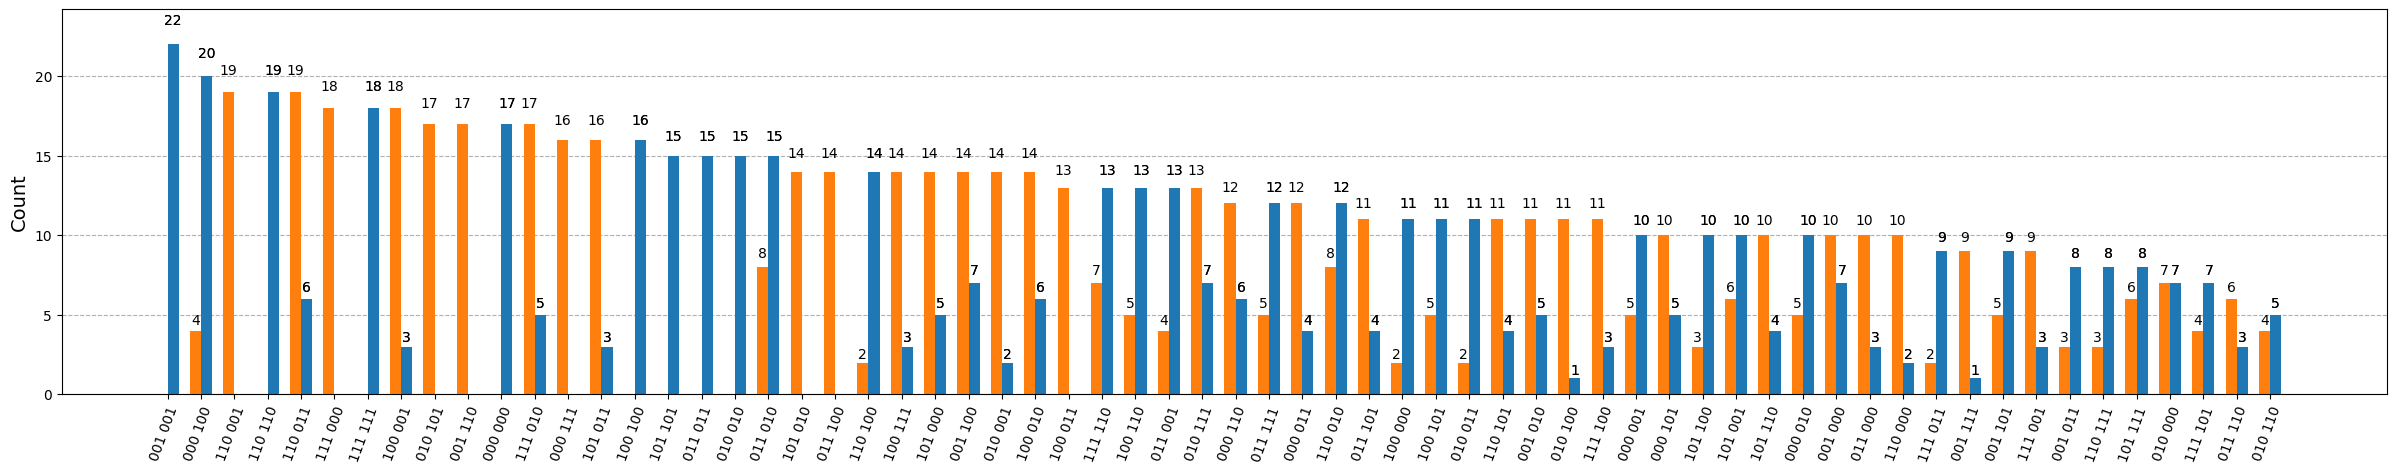

In [20]:
from qiskit.visualization import plot_histogram

even_counts = {k[2:]: v for k, v in counts.items() if k.startswith("0")}
odd_counts = {k[2:]: v for k, v in counts.items() if k.startswith("1")}

plot_histogram([even_counts, odd_counts], figsize=(30, 5), sort="value_desc")

### Process counts to amplitudes: Formate and Average

In [21]:
def stringify_state(state):
    """
    >>> stringify_state([[0, 0], [0, 1], [1, 1]])
    ['00', '01', '11']

    >>> stringify_state(4)
    ['00', '01', '10', '11']

    >>> stringify_state(8)
    ['000', '001', '010', '100', '011', '101', '110', '111']
    """
    if isinstance(state, int):
        n_data_qubits = int(log2(state))
        return sorted(
            [bin(i)[2:].zfill(n_data_qubits) for i in range(state)],
            key=lambda x: sum(int(i) for i in x),
        )
    return ["".join(map(str, s)) for s in state]

In [22]:
def formate_amplitudes(x, y, counts, lite):
    """Process counts average amplitudes"""
    nx = x if isinstance(x, int) else x.shape[0]
    ny = y if isinstance(y, int) else y.shape[0]

    ampl = np.zeros((nx, ny, 2))
    shots = sum(v for _, v in counts.items())
    noise_shots = 0

    xstates = {s: i for i, s in enumerate(stringify_state(x))}
    ystates = {s: i for i, s in enumerate(stringify_state(y))}
    astates = {"0": 0, "1": 1}

    for state, count in counts.items():
        astate, ystate, xstate = state.split()
        if lite:
            xstate = "".join(x.flatten().astype(str))

        if astate in astates and xstate in xstates and ystate in ystates:
            ampl[xstates[xstate], ystates[ystate], astates[astate]] = count

        else:
            noise_shots += count
            print(f"Excess state {state} with count {count}")

    if noise_shots:
        print(f"Noise shouts {noise_shots} form {shots}")

    # Averaging
    ampl /= shots - noise_shots
    ampl *= nx * ny
    np.clip(ampl, 0, 1, out=ampl)
    return ampl

In [23]:
def average_amplitudes(ampl):
    ampl = (ampl[:, :, 0] + (1 - ampl[:, :, 1])) / 2
    ampl = (ampl + ampl.T) / 2
    return ampl

In [24]:
x, y = 2**n_data_qubits, 2**n_data_qubits

In [25]:
ampl_formated = formate_amplitudes(x, y, counts, lite=False)

In [26]:
ampl_averaged = average_amplitudes(ampl_formated)

In [27]:
def heatmap(ax, mat, ylabels, xlabels, annotation=None, title=None, palette=None):
    if palette:
        ax.imshow(palette[mat], origin="lower", cmap="gray")

    else:
        ax.imshow(mat, origin="lower", cmap="gray")

    ax.set_xticks(range(0, len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=90, fontsize="20")
    ax.set_yticks(range(0, len(ylabels)))
    ax.set_yticklabels(ylabels, fontsize="20")
    if title:
        ax.set_title(title, fontsize="20")

    if annotation is not None:
        for i in range(annotation.shape[0]):
            for j in range(annotation.shape[1]):
                ax.text(j, i, annotation[i, j], ha="center", va="center", color="#FF0000", fontsize="20")

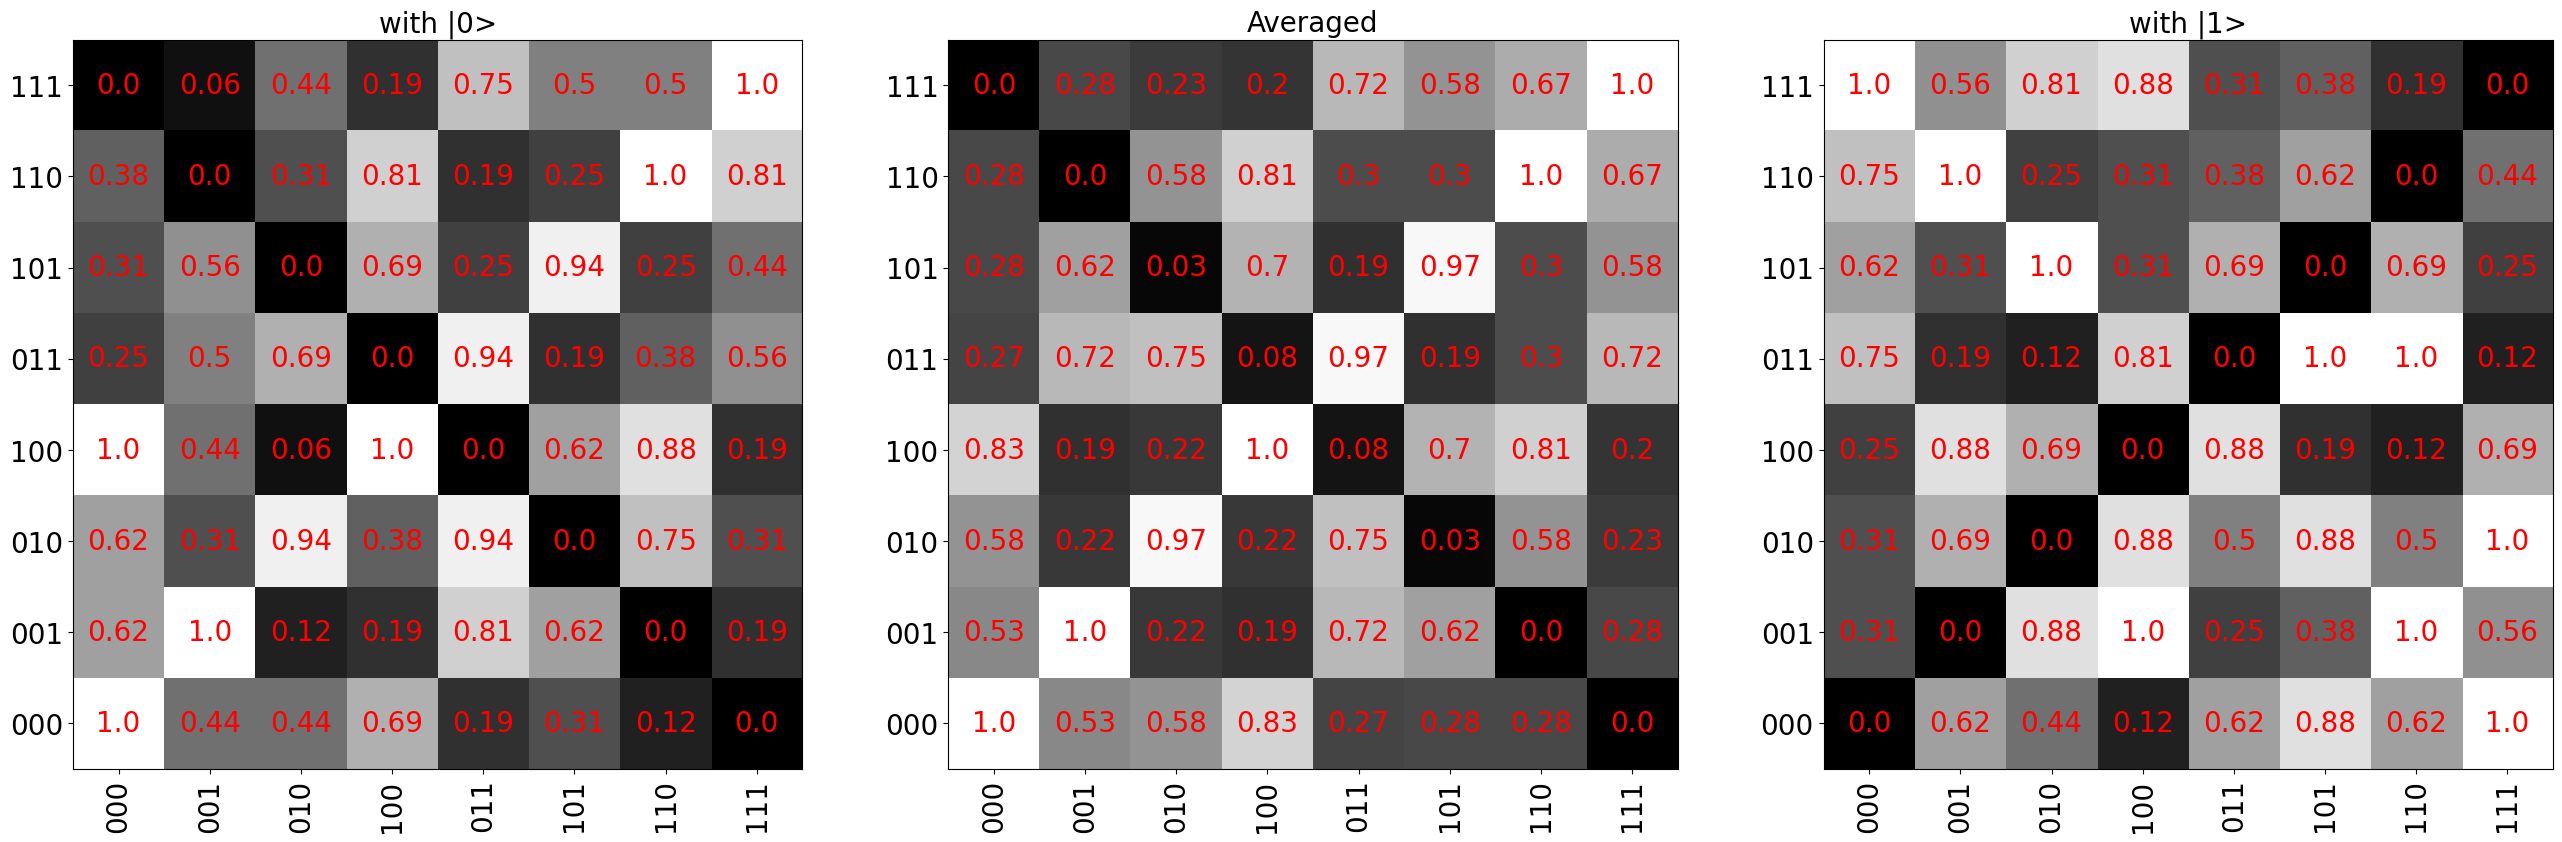

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(32, 10))

xlabels, ylabels = stringify_state(x), stringify_state(y)

heatmap(
    axes[0],
    ampl_formated[:, :, 0],
    xlabels,
    ylabels,
    annotation=ampl_formated[:, :, 0].round(2),
    title="with |0>",
)
heatmap(
    axes[1],
    ampl_averaged,
    xlabels,
    ylabels,
    annotation=ampl_averaged.round(2),
    title="Averaged",
)
heatmap(
    axes[2],
    ampl_formated[:, :, 1],
    xlabels,
    ylabels,
    annotation=ampl_formated[:, :, 1].round(2),
    title="with |1>",
)

### Extract Hamming distance

In [29]:
def extract_hamming_distance(x, y, ampl):
    n_data_qubits = min_qubits_for_data_encoding(x)
    return np.arccos(np.sqrt(ampl)) * 2 * n_data_qubits / pi

In [30]:
hdist = extract_hamming_distance(x, y, ampl_averaged)

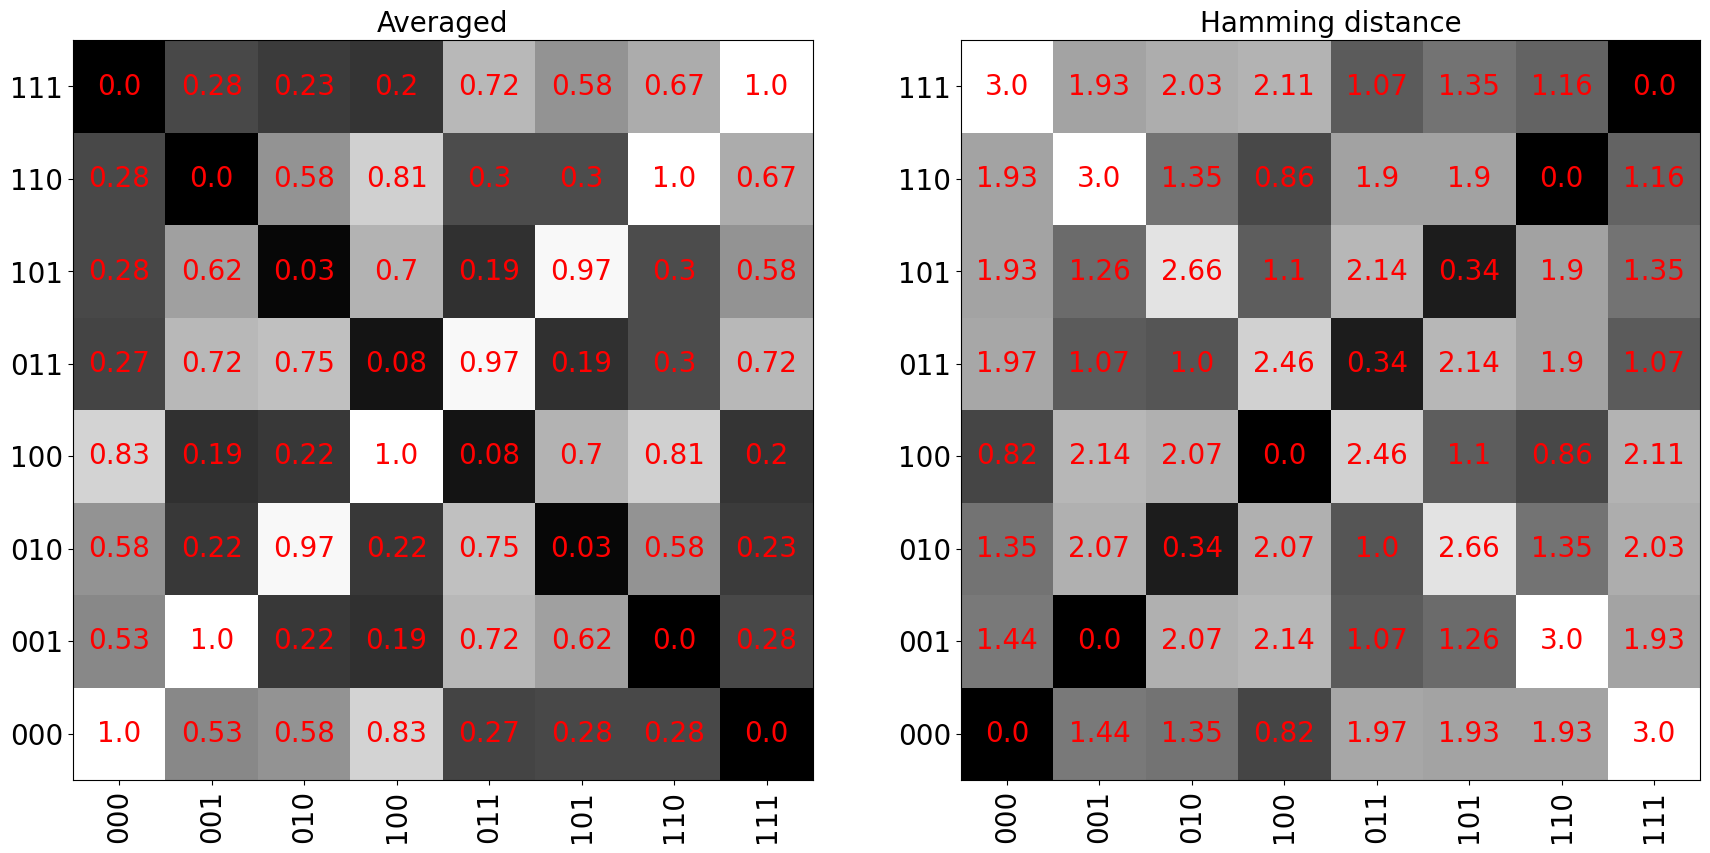

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(21, 10))

xlabels, ylabels = stringify_state(x), stringify_state(y)

heatmap(
    axes[0],
    ampl_averaged,
    xlabels,
    ylabels,
    annotation=ampl_averaged.round(2),
    title="Averaged",
)
heatmap(
    axes[1],
    hdist,
    xlabels,
    ylabels,
    annotation=hdist.round(2),
    title="Hamming distance",
)

### Fit limit and neighbors

In [32]:
from scipy.spatial import distance


def _arrify_state(state):
    if isinstance(state, np.ndarray):
        return state
    if isinstance(state, int):
        return np.array([list(map(int, s)) for s in stringify_state(state)])


def hdist_exact(x, y):
    x_arr = _arrify_state(x)
    y_arr = _arrify_state(y)
    hdist = distance.cdist(x_arr, y_arr, metric="hamming") * x_arr.shape[1]
    return hdist


def fit_neighbors(x, y, hdist, limit):
    neighbors = hdist < limit
    hdist_expected = hdist_exact(x, y)
    neighbors_expected = hdist_expected < limit
    x_arr = _arrify_state(x)
    y_arr = _arrify_state(y)
    errors = np.array([[" "] * x_arr.shape[0] for _ in range(y_arr.shape[0])])
    errors[(neighbors_expected != neighbors) & neighbors_expected] = "?"
    errors[(neighbors_expected != neighbors) & ~neighbors_expected] = "x"

    return neighbors, neighbors_expected, errors

In [33]:
def n_error(x, y, hdist, l):
    _, n, err = fit_neighbors(x, y, hdist, l)
    return (err != " ").sum() / 2

In [34]:
def fit_limit(x, y, hdist, neighbour, full=False, a_tol=None, ax=None):
    a_tol = a_tol or 1e-1
    limits_start, limits_end = neighbour + a_tol, neighbour + 1 - a_tol
    limits_steps = np.ceil((limits_end - limits_start) / a_tol).astype(int)

    limits = np.linspace(limits_start, limits_end, limits_steps)
    n_errors = [n_error(x, y, hdist, l) for l in limits]
    argmin_n_errors = np.argmin(n_errors)
    limit, error = limits[argmin_n_errors], n_errors[argmin_n_errors]
    if ax is not None:
        if full:
            limits_start, limits_end = 0, min_qubits_for_data_encoding(x)
            limits_steps = np.ceil((limits_end - limits_start) / a_tol).astype(int)
            limits = np.linspace(limits_start, limits_end, limits_steps)
            n_errors = [n_error(x, y, hdist, l) for l in limits]
        ax.plot(limits, n_errors)
        ax.plot([limit] * 2, (0, max(n_errors)))
        ax.set_xlabel("limit value")
        ax.set_ylabel("err")
        ax.grid()
    return limit, error

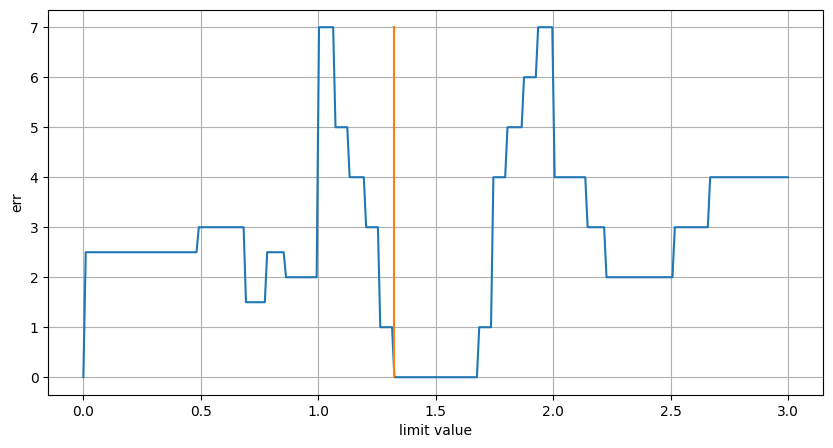

In [35]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

limit, error = fit_limit(x, y, hdist, 1, full=True, a_tol=1e-2, ax=ax)

In [36]:
neighbors, neighbors_expected, errors = fit_neighbors(x, y, hdist, limit)

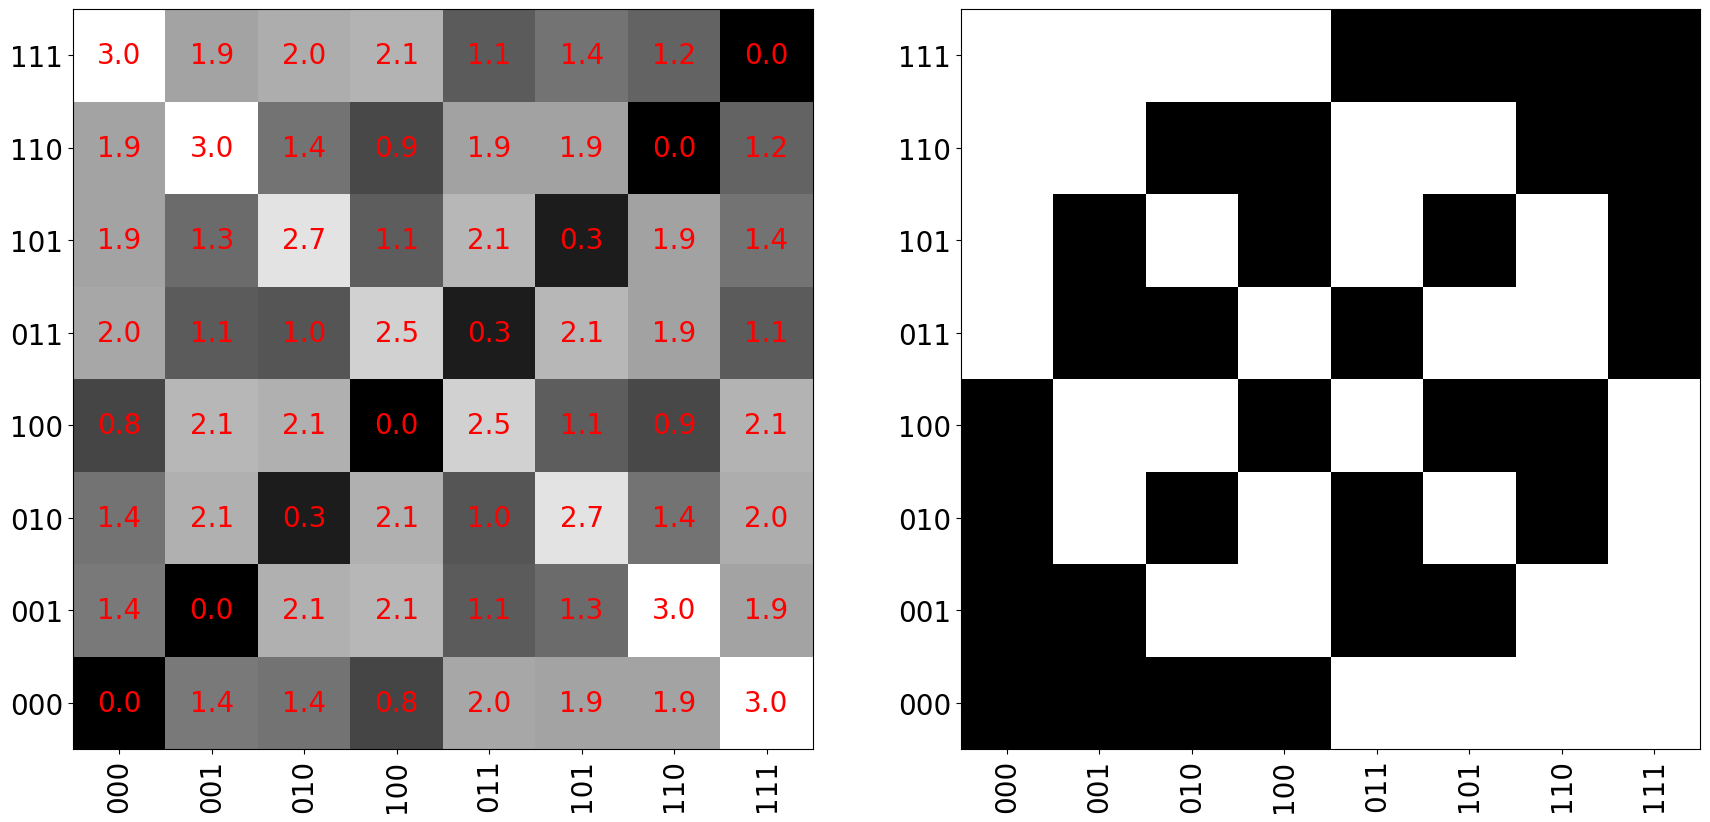

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(21, 10))

xlabels, ylabels = stringify_state(x), stringify_state(y)

heatmap(axes[0], hdist, xlabels, ylabels, annotation=hdist.round(1))
heatmap(axes[1], ~neighbors, xlabels, ylabels, annotation=errors)

## IBM backend

In [38]:
from qiskit_ibm_runtime import QiskitRuntimeService

%time service = QiskitRuntimeService()

CPU times: user 335 ms, sys: 51.2 ms, total: 387 ms
Wall time: 6.94 s


In [39]:
%time print(*(s.name for s in service.backends()), sep="\n")

ibm_brisbane
ibm_kyiv
ibm_sherbrooke
CPU times: user 143 ms, sys: 11.3 ms, total: 154 ms
Wall time: 5.83 s


In [40]:
ibm_backend = service.backend("ibm_sherbrooke")

### Transpiling

In [41]:
def transpile(circuit, backend, maps=None):
    cicruit_name = circuit.name
    if maps is None:
        from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

        pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
        circuit = pm.run(circuit)
        circuit.name = f"{cicruit_name}-auto_tanspiled"
        return circuit

    from collections import ChainMap

    layout = dict(ChainMap(*({r[i]: v for i, v in enumerate(map_)} for r, map_ in zip(circuit.qregs, maps))))
    import qiskit.compiler

    circuit = qiskit.compiler.transpile(circuit, backend, initial_layout=layout)
    circuit.name = f"{cicruit_name}-manual_tanspiled"
    return circuit

## Research of tomography on noise simulator

In [42]:
def hdist_tomography_from_result(result, x, y):
    counts = result.get_counts(0)
    ampl = formate_amplitudes(x, y, counts, lite=False)
    ampl = average_amplitudes(ampl)
    hdist = extract_hamming_distance(x, y, ampl)
    return hdist

In [43]:
%time noise_simulator = AerSimulator.from_backend(ibm_backend)

CPU times: user 2.21 s, sys: 26.5 ms, total: 2.23 s
Wall time: 6.73 s


### Example of tomography on noise simulator with auto transpiling and swaped ancilla

In [44]:
n_data_qubits, n_auxilia_qubits = 5, 5

In [45]:
shots = 120_000
shots

120000

In [46]:
circuit = hamdist_full_tomography_circuit(n_data_qubits, n_auxilia_qubits).decompose(reps=5)
circuit = transpile(circuit, ibm_backend)
circuit.draw(fold=-1, idle_wires=False)

global phase: π/4
           ┌─────────┐┌────┐┌─────────┐ ░ ┌──────────┐┌────┐  ┌─────────┐   ┌──────┐ ┌─────────┐ ┌────┐ ┌────────┐  ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ░ ┌──────────┐┌────┐  ┌─────────┐   ┌──────┐ ┌─────────┐ ┌────┐ ┌────────┐  ░                ┌─┐         
 y_1 -> 98 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(-π/2) ├┤ √X ├──┤ Rz(π/2) ├───┤1     ├─┤ Rz(π/2) ├─┤ √X ├─┤ Rz(-π) ├──░─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤ Rz(-π/2) ├┤ √X ├──┤ Rz(π/2) ├───┤1     ├─┤ Rz(π/2) ├─┤ √X ├─┤ Rz(-π) ├──░────────────────┤M├─────────
           ├─────────┤├────┤├─────────┤ ░ ├─────────┬┘├────┤┌─┴─────────┴──┐│  Ecr │┌┴─────────┴┐├────┤┌┴────────┴┐ ░ ┌─────────┐                                                                                            ┌──────┐                                  ┌──────┐┌──────────┐                                                                                                                                                                                                                                                                                                                                                                                                   ░ ├─────────┬┘├────┤┌─┴─────────┴──┐│  Ecr │┌┴─────────┴┐├────┤┌┴────────┴┐ ░    ┌─┐         └╥┘         
 x_1 -> 99 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(π/2) ├─┤ √X ├┤ Rz(-0.44777) ├┤0     ├┤ Rz(1.123) ├┤ √X ├┤ Rz(-π/2) ├─░─┤ Rz(π/2) ├────────────────────────────────────────────────────────────────────────────────────────────┤0     ├──────────────────────────────────┤0     ├┤ Rz(-π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤ Rz(π/2) ├─┤ √X ├┤ Rz(-0.44777) ├┤0     ├┤ Rz(1.123) ├┤ √X ├┤ Rz(-π/2) ├─░────┤M├──────────╫──────────
           └─────────┘└────┘└─────────┘ ░ └─────────┘ └────┘└──────────────┘└──────┘└───────────┘└────┘└──────────┘ ░ ├─────────┤   ┌────┐  ┌──────────────┐┌──────┐┌────────┐┌────┐┌──────────┐┌────┐┌──────┐┌─────────────┐│  Ecr │┌────────┐┌────┐┌──────────┐┌────┐│  Ecr │└┬────────┬┘┌────┐┌─────────┐┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐┌─────────┐ ┌────┐┌──────────┐                                                                                                                                                                                                                                                                   ░ └─────────┘ └────┘└──────────────┘└──────┘└───────────┘└────┘└──────────┘ ░    └╥┘          ║          
a_0 -> 100 ─────────────────────────────░─────────────────────────────────────────────────────────────

In [47]:
def run_on_backend(backend, cricuit, shots: int, cache=True) -> qiskit.result.Result:
    path = Path.cwd() / "assets" / f"result-{circuit.name}-{backend.name}-{shots}.json"
    if cache and path.exists():
        print(f"Result already exist on '{path.relative_to(Path.cwd())}'!")
        result = qiskit.result.Result.from_dict(json.loads(path.read_text()))
        return result
    job = backend.run(circuit, shots=shots)
    result = job.result()
    if cache:
        print(f"Result of shots={shots} saved on '{path.relative_to(Path.cwd())}'!")
        path.write_text(json.dumps(result.to_dict()))
    return result

In [48]:
%time result = run_on_backend(noise_simulator, circuit, shots)

Result already exist on 'assets/result-hd_full_tomography-circuit-nd5-na5-auto_tanspiled-aer_simulator_from(ibm_sherbrooke)-120000.json'!
CPU times: user 477 μs, sys: 146 μs, total: 623 μs
Wall time: 558 μs


In [49]:
x, y = 2**n_data_qubits, 2**n_data_qubits
%time hdist = hdist_tomography_from_result(result, x, y)

CPU times: user 5.29 ms, sys: 0 ns, total: 5.29 ms
Wall time: 5.23 ms


1.808144329896907 0.0
2.4 0.0


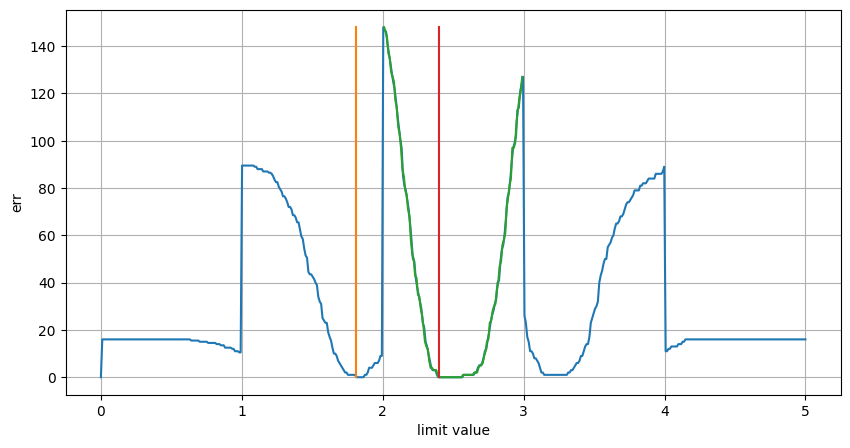

In [50]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

limit, error = fit_limit(x, y, hdist, 1, full=True, a_tol=1e-2, ax=ax)
print(limit, error)
limit, error = fit_limit(x, y, hdist, 2, full=False, a_tol=1e-2, ax=ax)
print(limit, error)
ax.grid()

### Research min number of shots

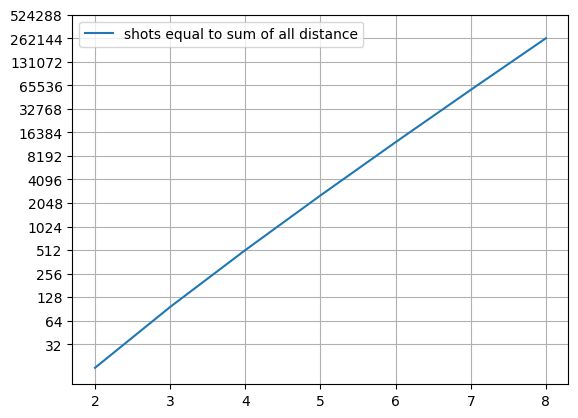

In [46]:
_, ax = plt.subplots(1, 1)
data_qubits_span = list(range(2, 9))
min_shots_span = [hdist_exact(2**i, 2**i).sum() for i in data_qubits_span]
ax.plot(data_qubits_span, min_shots_span, label="shots equal to sum of all distance")
ax.set_yscale("log", base=2)
ax.set_yticks([2**i for i in range(5, 20)])
ax.set_yticklabels([2**i for i in range(5, 20)])
ax.grid()
ax.legend()

### Reserch optimal number of shots

In [47]:
import joblib
from tqdm import tqdm


def neighbors_errors_over_shots(circuit, x, y, backend, shots_span=None, n_jobs=1):
    n_data_qubits = min_qubits_for_data_encoding(x)
    shots_span = shots_span or np.linspace(1024, 2**14, 51)

    def _estimate_errors(circuit, backend, shots, x, y):
        job = backend.run(circuit, shots=shots)
        result = job.result()
        hdist = hdist_tomography_from_result(result, x, y)
        errs = [fit_limit(x, y, hdist, neighbour=n) for n in range(1, n_data_qubits // 2 + 1)]
        return errs

    errors = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(_estimate_errors)(circuit, backend, s, x, y) for s in tqdm(shots_span)
    )

    return shots_span, errors

In [ ]:
shots_span, errors = neighbors_errors_over_shots(circuit, x, y, noise_simulator, n_jobs=-2)

In [ ]:
limits_and_errors1, limits_and_errors2 = list(zip(*errors))

In [ ]:
limit_span1, error_span_1 = list(zip(*limits_and_errors1))

In [ ]:
limit_span2, error_span_2 = list(zip(*limits_and_errors2))

7475.2 0.0
8089.599999999999 0.0


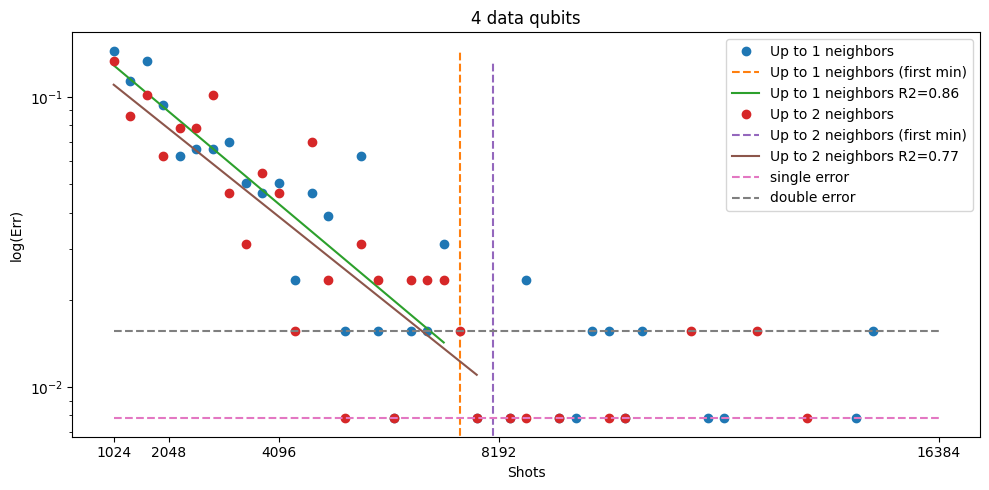

In [ ]:
def line(x, a, b):
    return a * x + b


from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

_, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, err_span in enumerate((error_span_1, error_span_2), 1):
    ax.plot(shots_span, err_span, "o", label=f"Up to {i} neighbors")
    err_span_argmin = np.argmin(err_span)
    errors_last_, shots_span_ = err_span[:err_span_argmin], shots_span[:err_span_argmin]
    params, params_covariance = curve_fit(line, shots_span_, np.log(errors_last_), p0=(1e-3, 1))
    # print(params, params_covariance)
    r2 = r2_score(errors_last_, np.exp(line(shots_span_, *params)))
    ax.plot(
        (shots_span[err_span_argmin], shots_span[err_span_argmin]),
        (0, max(err_span)),
        "--",
        label=f"Up to {i} neighbors (first min)",
    )
    print(shots_span[err_span_argmin], err_span[err_span_argmin])
    ax.plot(
        shots_span_,
        np.exp(func(shots_span_, *params)),
        label=f"Up to {i} neighbors R2={r2:.2}",
    )

    # min_single_error_rate = 1 / (
    #     2**(2 * min_qubits_for_data_encoding(x)) / 2 + 2**min_qubits_for_data_encoding(x) / 2
    # )
min_single_error_rate = 2 / 2 ** (2 * min_qubits_for_data_encoding(x))
min_double_error_rate = 4 / 2 ** (2 * min_qubits_for_data_encoding(x))
ax.plot(
    shots_span,
    [min_single_error_rate for _ in range(len(shots_span))],
    "--",
    label="single error",
)
ax.plot(
    shots_span,
    [min_double_error_rate for _ in range(len(shots_span))],
    "--",
    label="double error",
)

ax.set_yscale("log")
ax.set_xlabel("Shots")
ax.set_ylabel("log(Err)")
ax.set_xticks([2**n for n in range(10, 15)])
ax.legend()
ax.set_title(f"{min_qubits_for_data_encoding(x)} data qubits")
plt.tight_layout()
plt.savefig(f"./err_log-shots-n{min_qubits_for_data_encoding(x)}.pdf")

## Tomography on IBMQ 

### 4 data qubits with manual transpiling and ancillas swapping 

In [48]:
x, y, n_auxilia_qubits = 16, 16, 3

In [49]:
circuit = hamdist_tomography_circuit(x, y, n_auxilia_qubits, False).decompose(reps=5)

maps = [[99, 101, 117, 119], [98, 102, 116, 120], [100, 110, 118]]
circuit = transpile(circuit, ibm_backend, maps=maps)
circuit.draw(fold=-1, idle_wires=False)

global phase: 3π/4
           ┌─────────┐┌────┐┌─────────┐ ░    ┌────┐   ┌──────────┐          ┌──────┐┌──────────┐┌────┐┌─────────┐ ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ░    ┌────┐   ┌──────────┐          ┌──────┐┌──────────┐┌────┐┌─────────┐ ░             ┌─┐            
 y_0 -> 98 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░────┤ √X ├───┤ Rz(-π/2) ├──────────┤1     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├─░─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░────┤ √X ├───┤ Rz(-π/2) ├──────────┤1     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├─░─────────────┤M├────────────
           ├─────────┤├────┤├─────────┤ ░ ┌──┴────┴──┐└──┬────┬──┘┌────────┐│  Ecr │├─────────┬┘├────┤├─────────┤ ░ ┌──────────┐                              ┌──────┐   ┌───┐    ┌──────────┐          ┌──────┐    ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ░ ┌──┴────┴──┐└──┬────┬──┘┌────────┐│  Ecr │├─────────┬┘├────┤├─────────┤ ░ ┌─┐         └╥┘            
 x_0 -> 99 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(-π/2) ├──────────────────────────────┤0     ├───┤ X ├────┤ Rz(-π/2) ├──────────┤0     ├────┤ X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├─░─┤M├──────────╫─────────────
           └─────────┘└────┘└─────────┘ ░ └──────────┘   └────┘   └────────┘└──────┘└─────────┘ └────┘└─────────┘ ░ ├──────────┤   ┌────┐   ┌──────────┐┌────┐│  Ecr │┌──┴───┴───┐└──┬────┬──┘┌────────┐│  Ecr │┌───┴───┴───┐┌────┐┌────────┐┌──────┐┌──────────┐   ┌────┐   ┌────────┐┌──────┐┌────────┐┌────┐┌────────┐┌──────┐   ┌────┐   ┌──────────┐┌──────┐ ┌────────┐┌────┐┌─────────┐┌──────┐                                                                                                                                                                                                                                                                                               ░ └──────────┘   └────┘   └────────┘└──────┘└─────────┘ └────┘└─────────┘ ░ └╥┘          ║             
a_0 -> 100 ─────────────────────────────░────────────────────────────────────────

In [50]:
shots = 2**13
shots

8192

In [51]:
job = service.job("cw89p5r9ezk00080zv40")

In [52]:
result = job.result()
hdist = hdist_tomography_from_result(result, x, y)

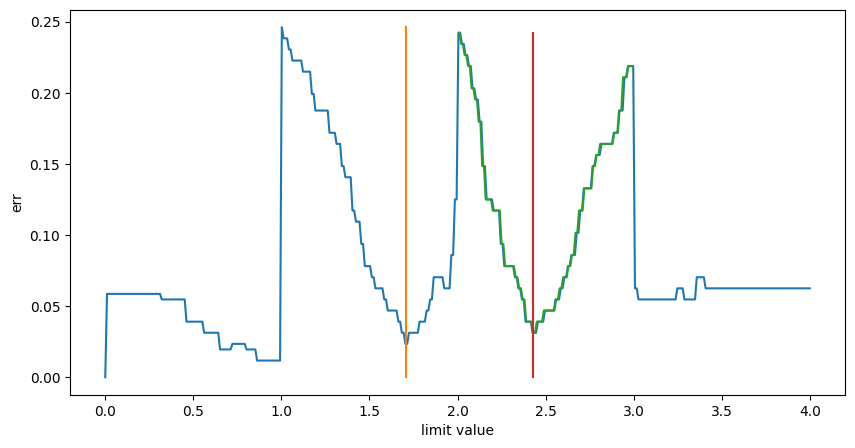

In [53]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

limit1, error1 = fit_limit(x, y, hdist, 1, full=True, a_tol=1e-2, ax=ax)
limit2, error2 = fit_limit(x, y, hdist, 2, full=False, a_tol=1e-2, ax=ax)

In [54]:
neighbors, neighbors_expected, errors = fit_neighbors(x, y, hdist, limit2)

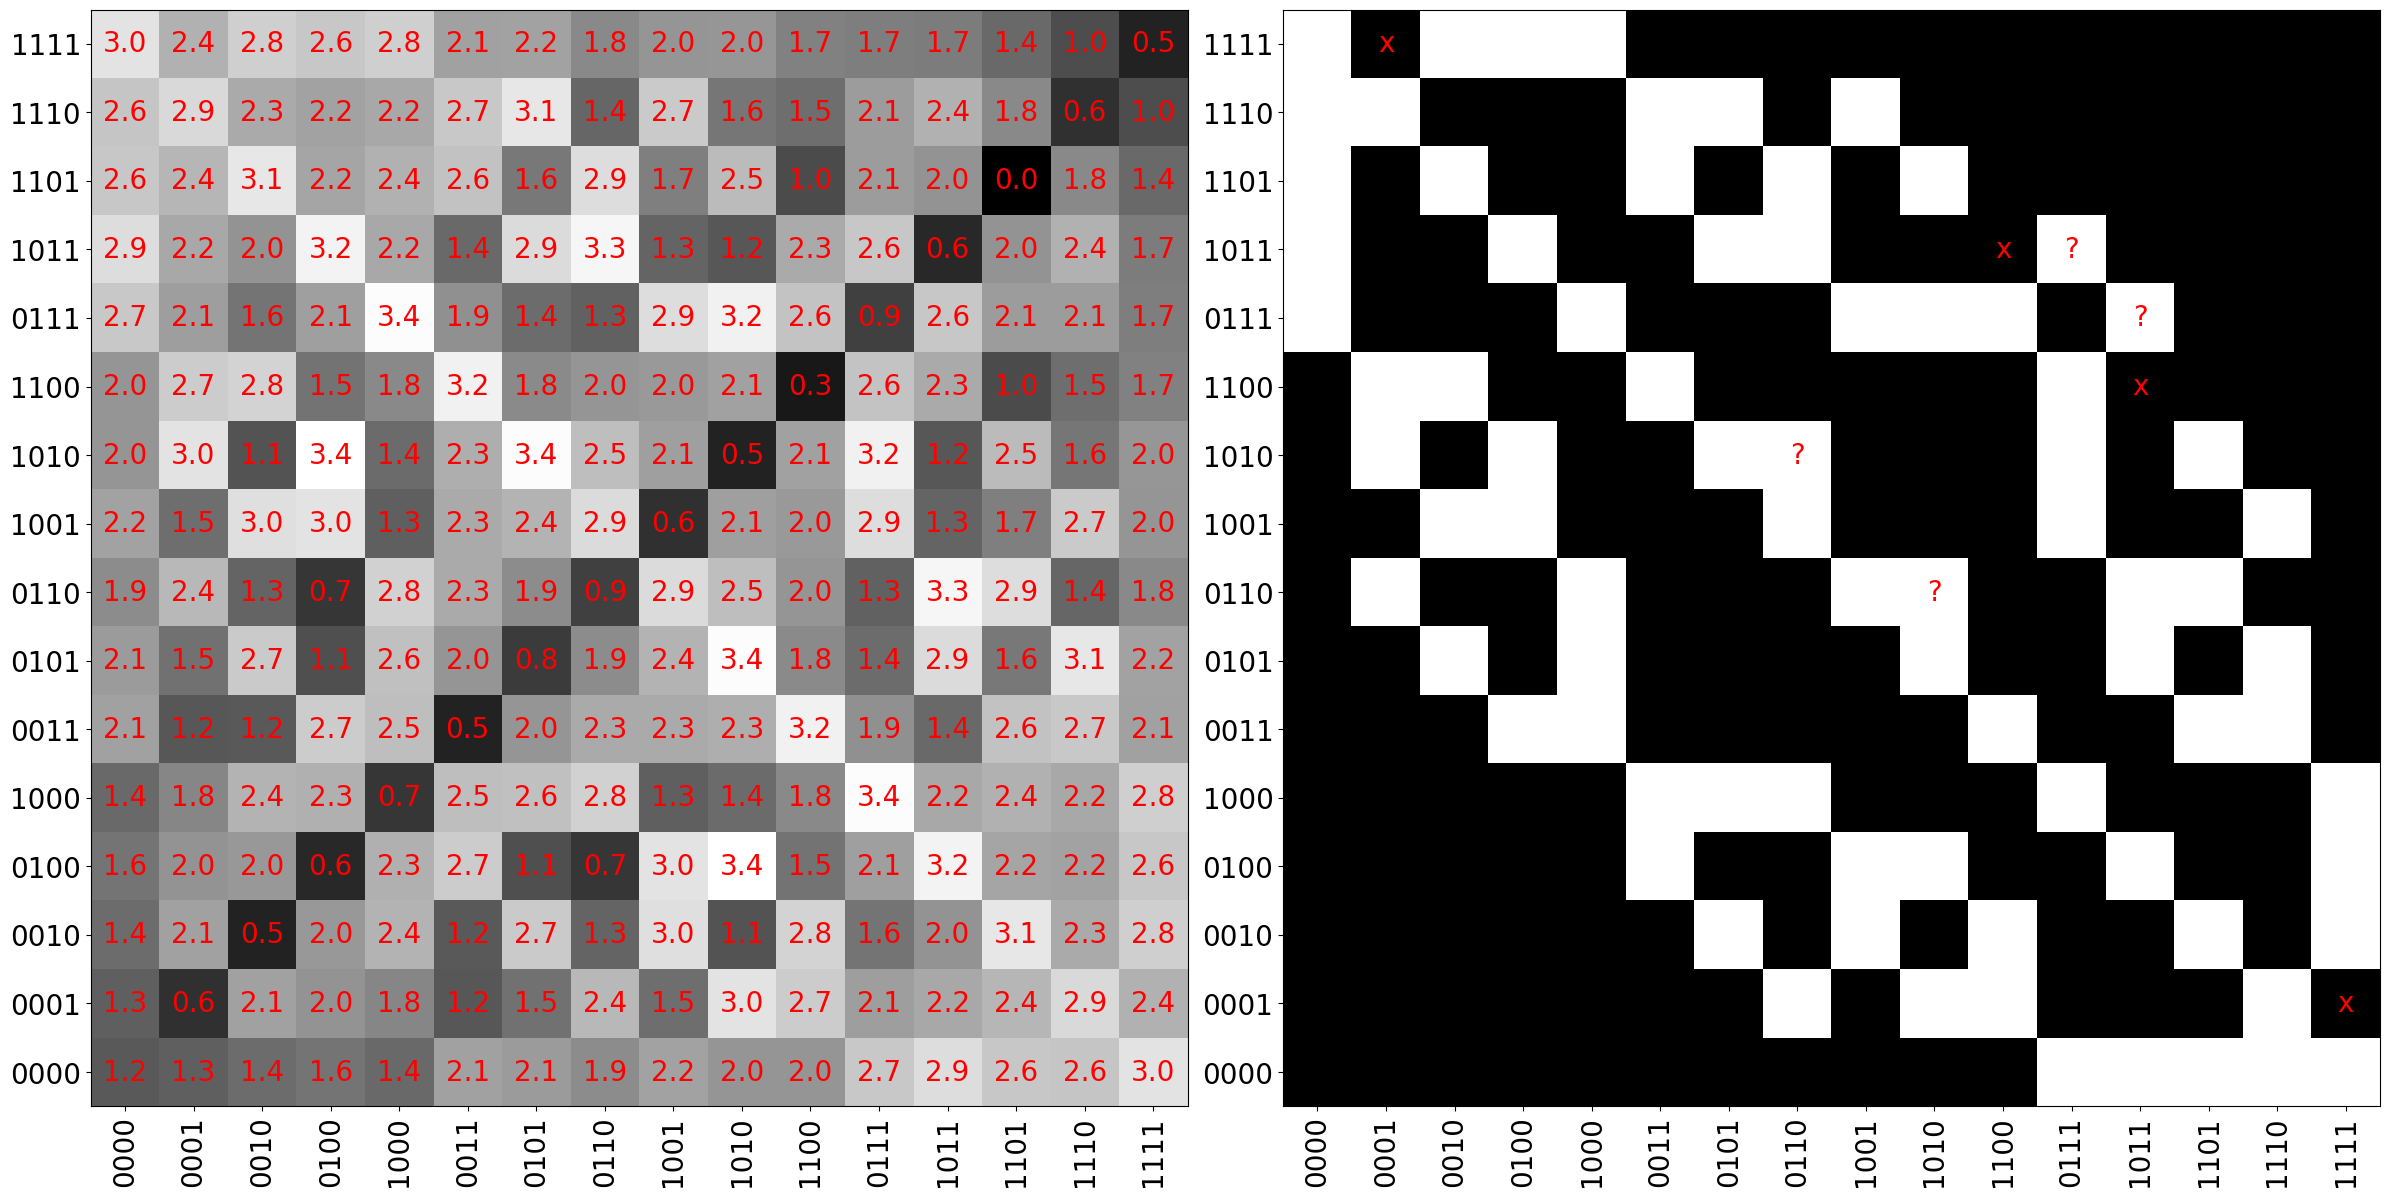

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

xlabels, ylabels = stringify_state(x), stringify_state(y)

heatmap(axes[0], hdist, xlabels, ylabels, annotation=hdist.round(1))
heatmap(axes[1], ~neighbors, xlabels, ylabels, annotation=errors)
fig.tight_layout()

### 5 data qubits with manual transpiling and ancillas swapping 

In [56]:
x, y, n_auxilia_qubits = 32, 32, 5

In [57]:
circuit = hamdist_tomography_circuit(x, y, n_auxilia_qubits, False).decompose(reps=5)

maps = [[109, 95, 91, 101, 110], [114, 94, 79, 102, 118], [96, 97, 98, 99, 100]]
circuit = transpile(circuit, ibm_backend, maps=maps)
circuit.draw(fold=-1, idle_wires=False)

global phase: π
           ┌─────────┐┌────┐┌─────────┐ ░ ┌──────────┐                      ┌──────┐   ┌───┐                                       ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ░ ┌──────────┐                      ┌──────┐   ┌───┐                                       ░                      ┌─┐         
 y_2 -> 79 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(-π/2) ├──────────────────────┤0     ├───┤ X ├───────────────────────────────────────░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤ Rz(-π/2) ├──────────────────────┤0     ├───┤ X ├───────────────────────────────────────░──────────────────────┤M├─────────
           ├─────────┤├────┤├─────────┤ ░ └┬────────┬┘   ┌────┐   ┌────────┐│  Ecr │   └───┘                                       ░    ┌────┐   ┌──────────┐                                                                                                                                                                                                                                                                                                                                                                                              ┌──────┐   ┌────┐                           ┌──────┐┌──────────┐   ┌────┐  ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                      ░ └┬────────┬┘   ┌────┐   ┌────────┐│  Ecr │   └───┘                                       ░       ┌─┐            └╥┘         
 x_2 -> 91 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──┤ Rz(-π) ├────┤ √X ├───┤ Rz(-π) ├┤1     ├───────────────────────────────────────────────░────┤ √X ├───┤ Rz(-π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├───┤ √X ├───────────────────────────┤1     ├┤ Rz(-π/2) ├───┤ √X ├──┤ Rz(π/2) ├─────────────────────────────

In [58]:
shots = 2**16
shots

65536

In [59]:
job = service.job("cw89yhajyrs0008gtfwg")

In [60]:
result = job.result()
hdist = hdist_tomography_from_result(result, x, y)

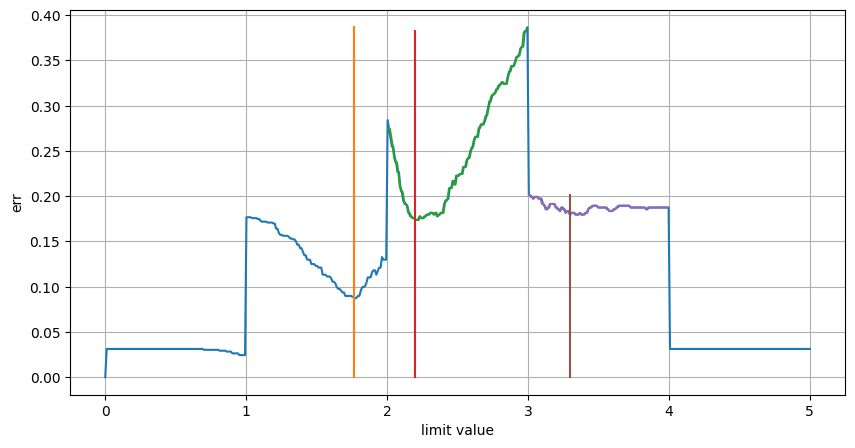

In [61]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

limit1, error1 = fit_limit(x, y, hdist, 1, full=True, a_tol=1e-2, ax=ax)
limit2, error2 = fit_limit(x, y, hdist, 2, full=False, a_tol=1e-2, ax=ax)
limit3, error3 = fit_limit(x, y, hdist, 3, full=False, a_tol=1e-2, ax=ax)

In [62]:
neighbors, neighbors_expected, errors = fit_neighbors(x, y, hdist, limit2)

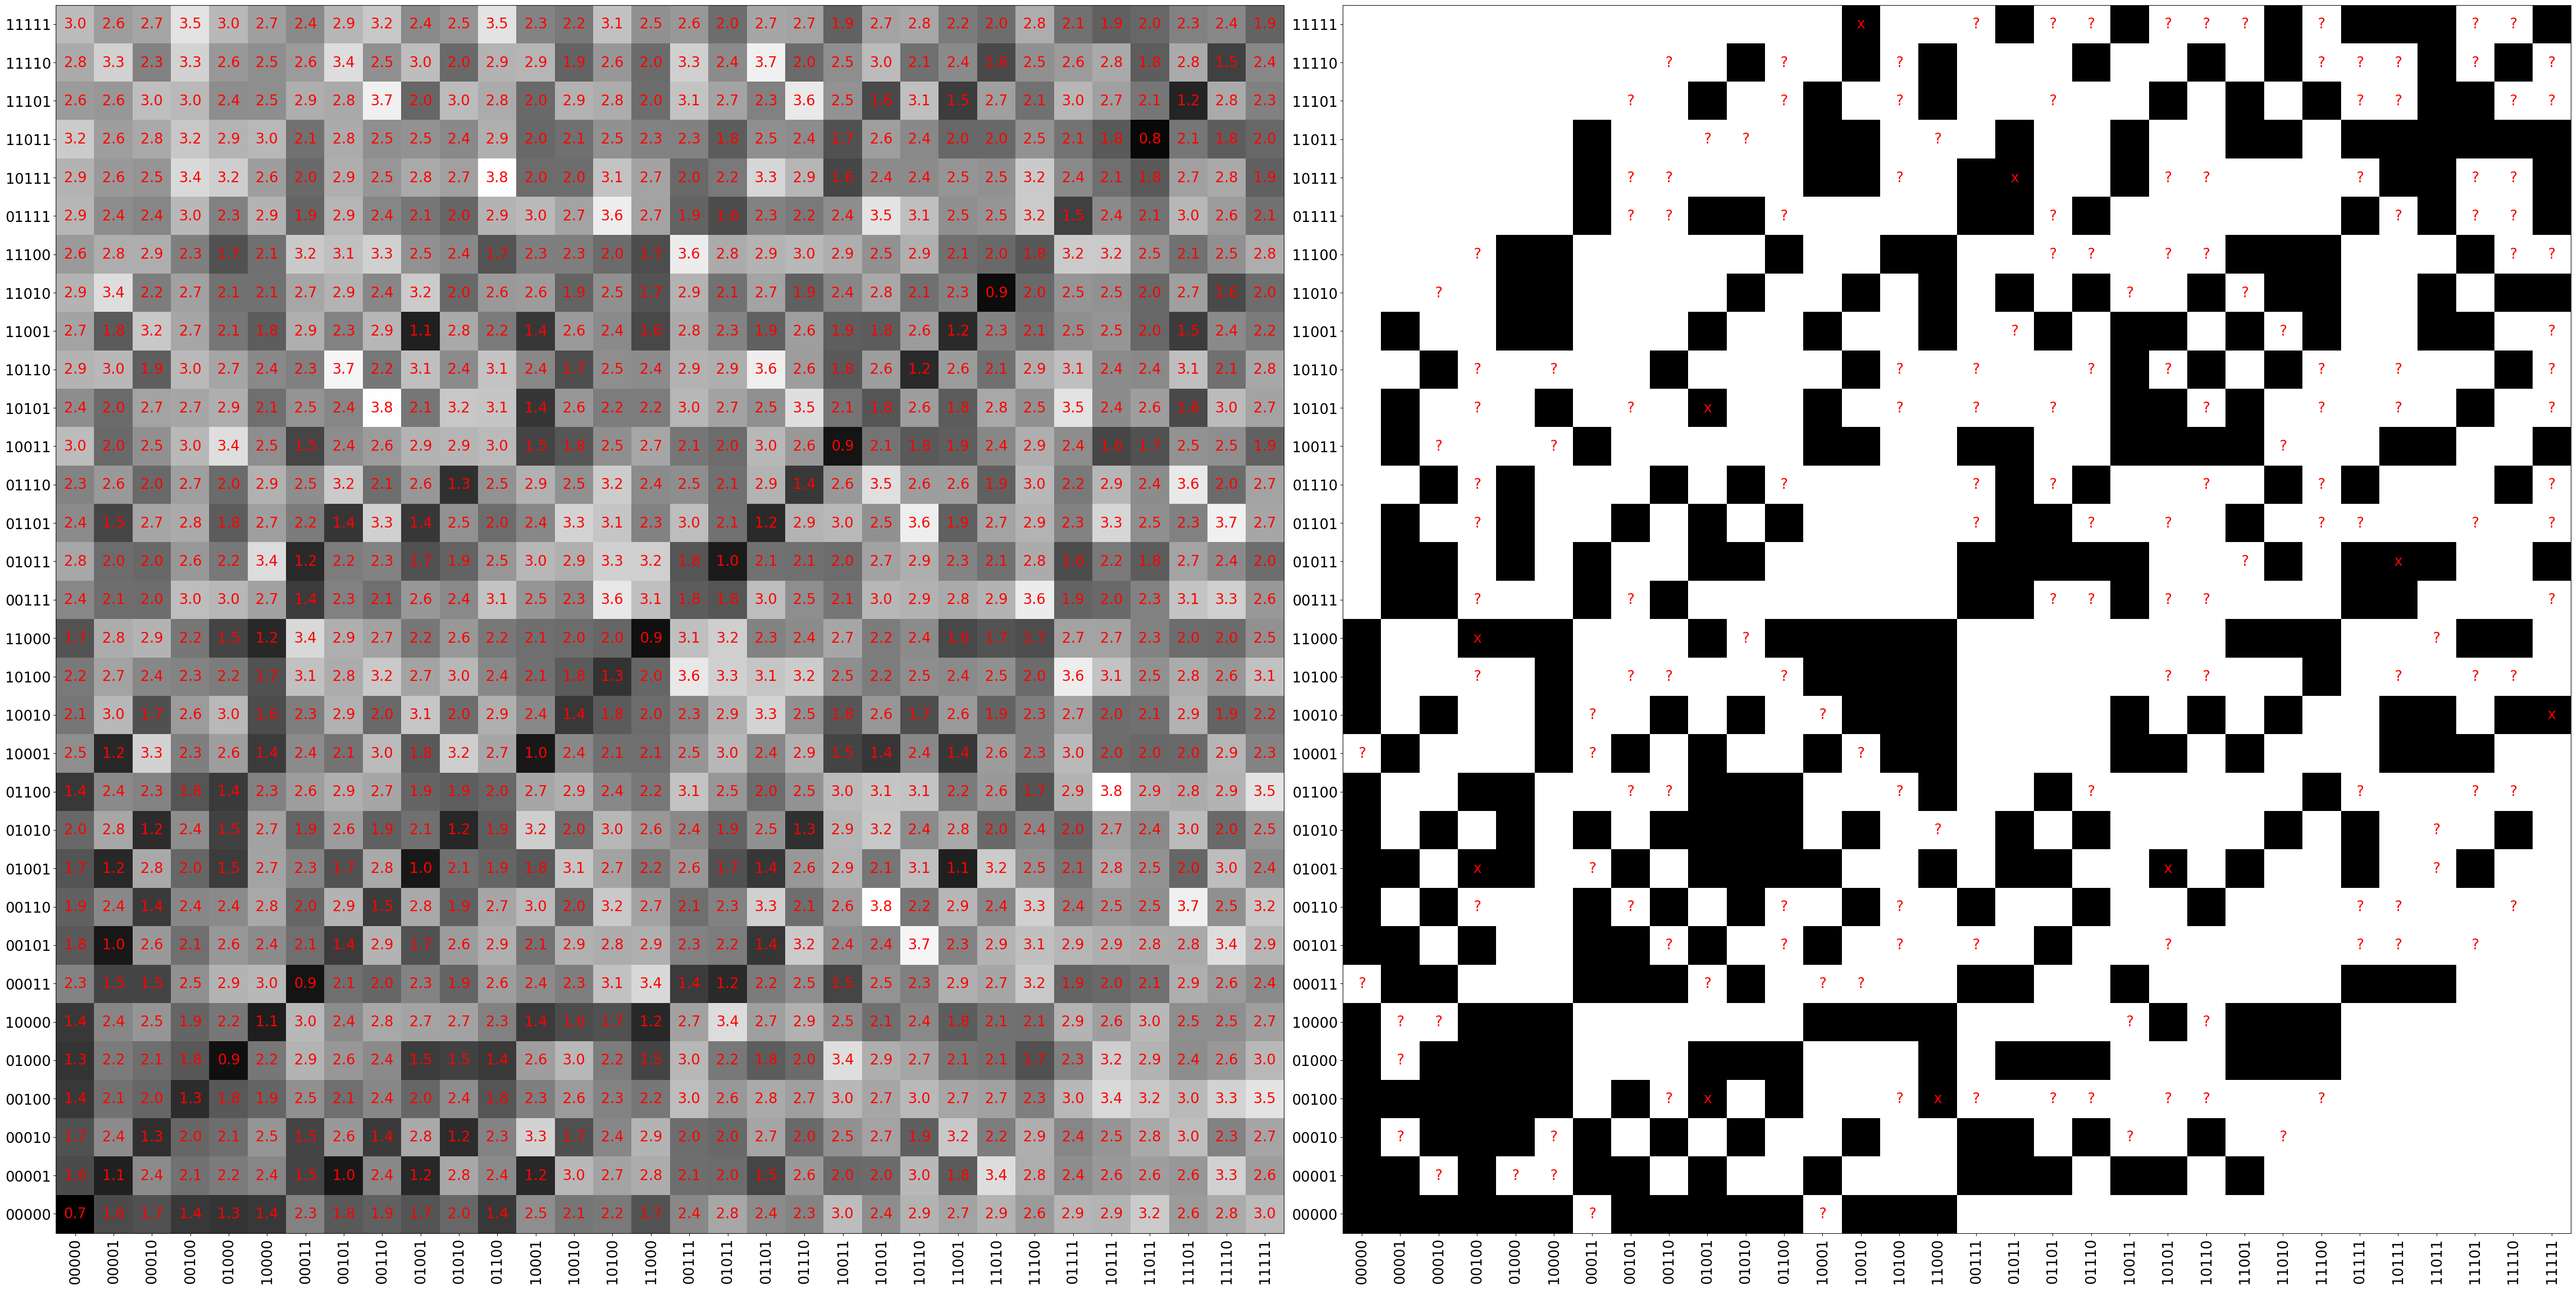

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(50, 25))

xlabels, ylabels = stringify_state(x), stringify_state(y)

heatmap(axes[0], hdist, xlabels, ylabels, annotation=hdist.round(1))
heatmap(axes[1], ~neighbors, xlabels, ylabels, annotation=errors)
fig.tight_layout()

#### Figure of tomography result for paper

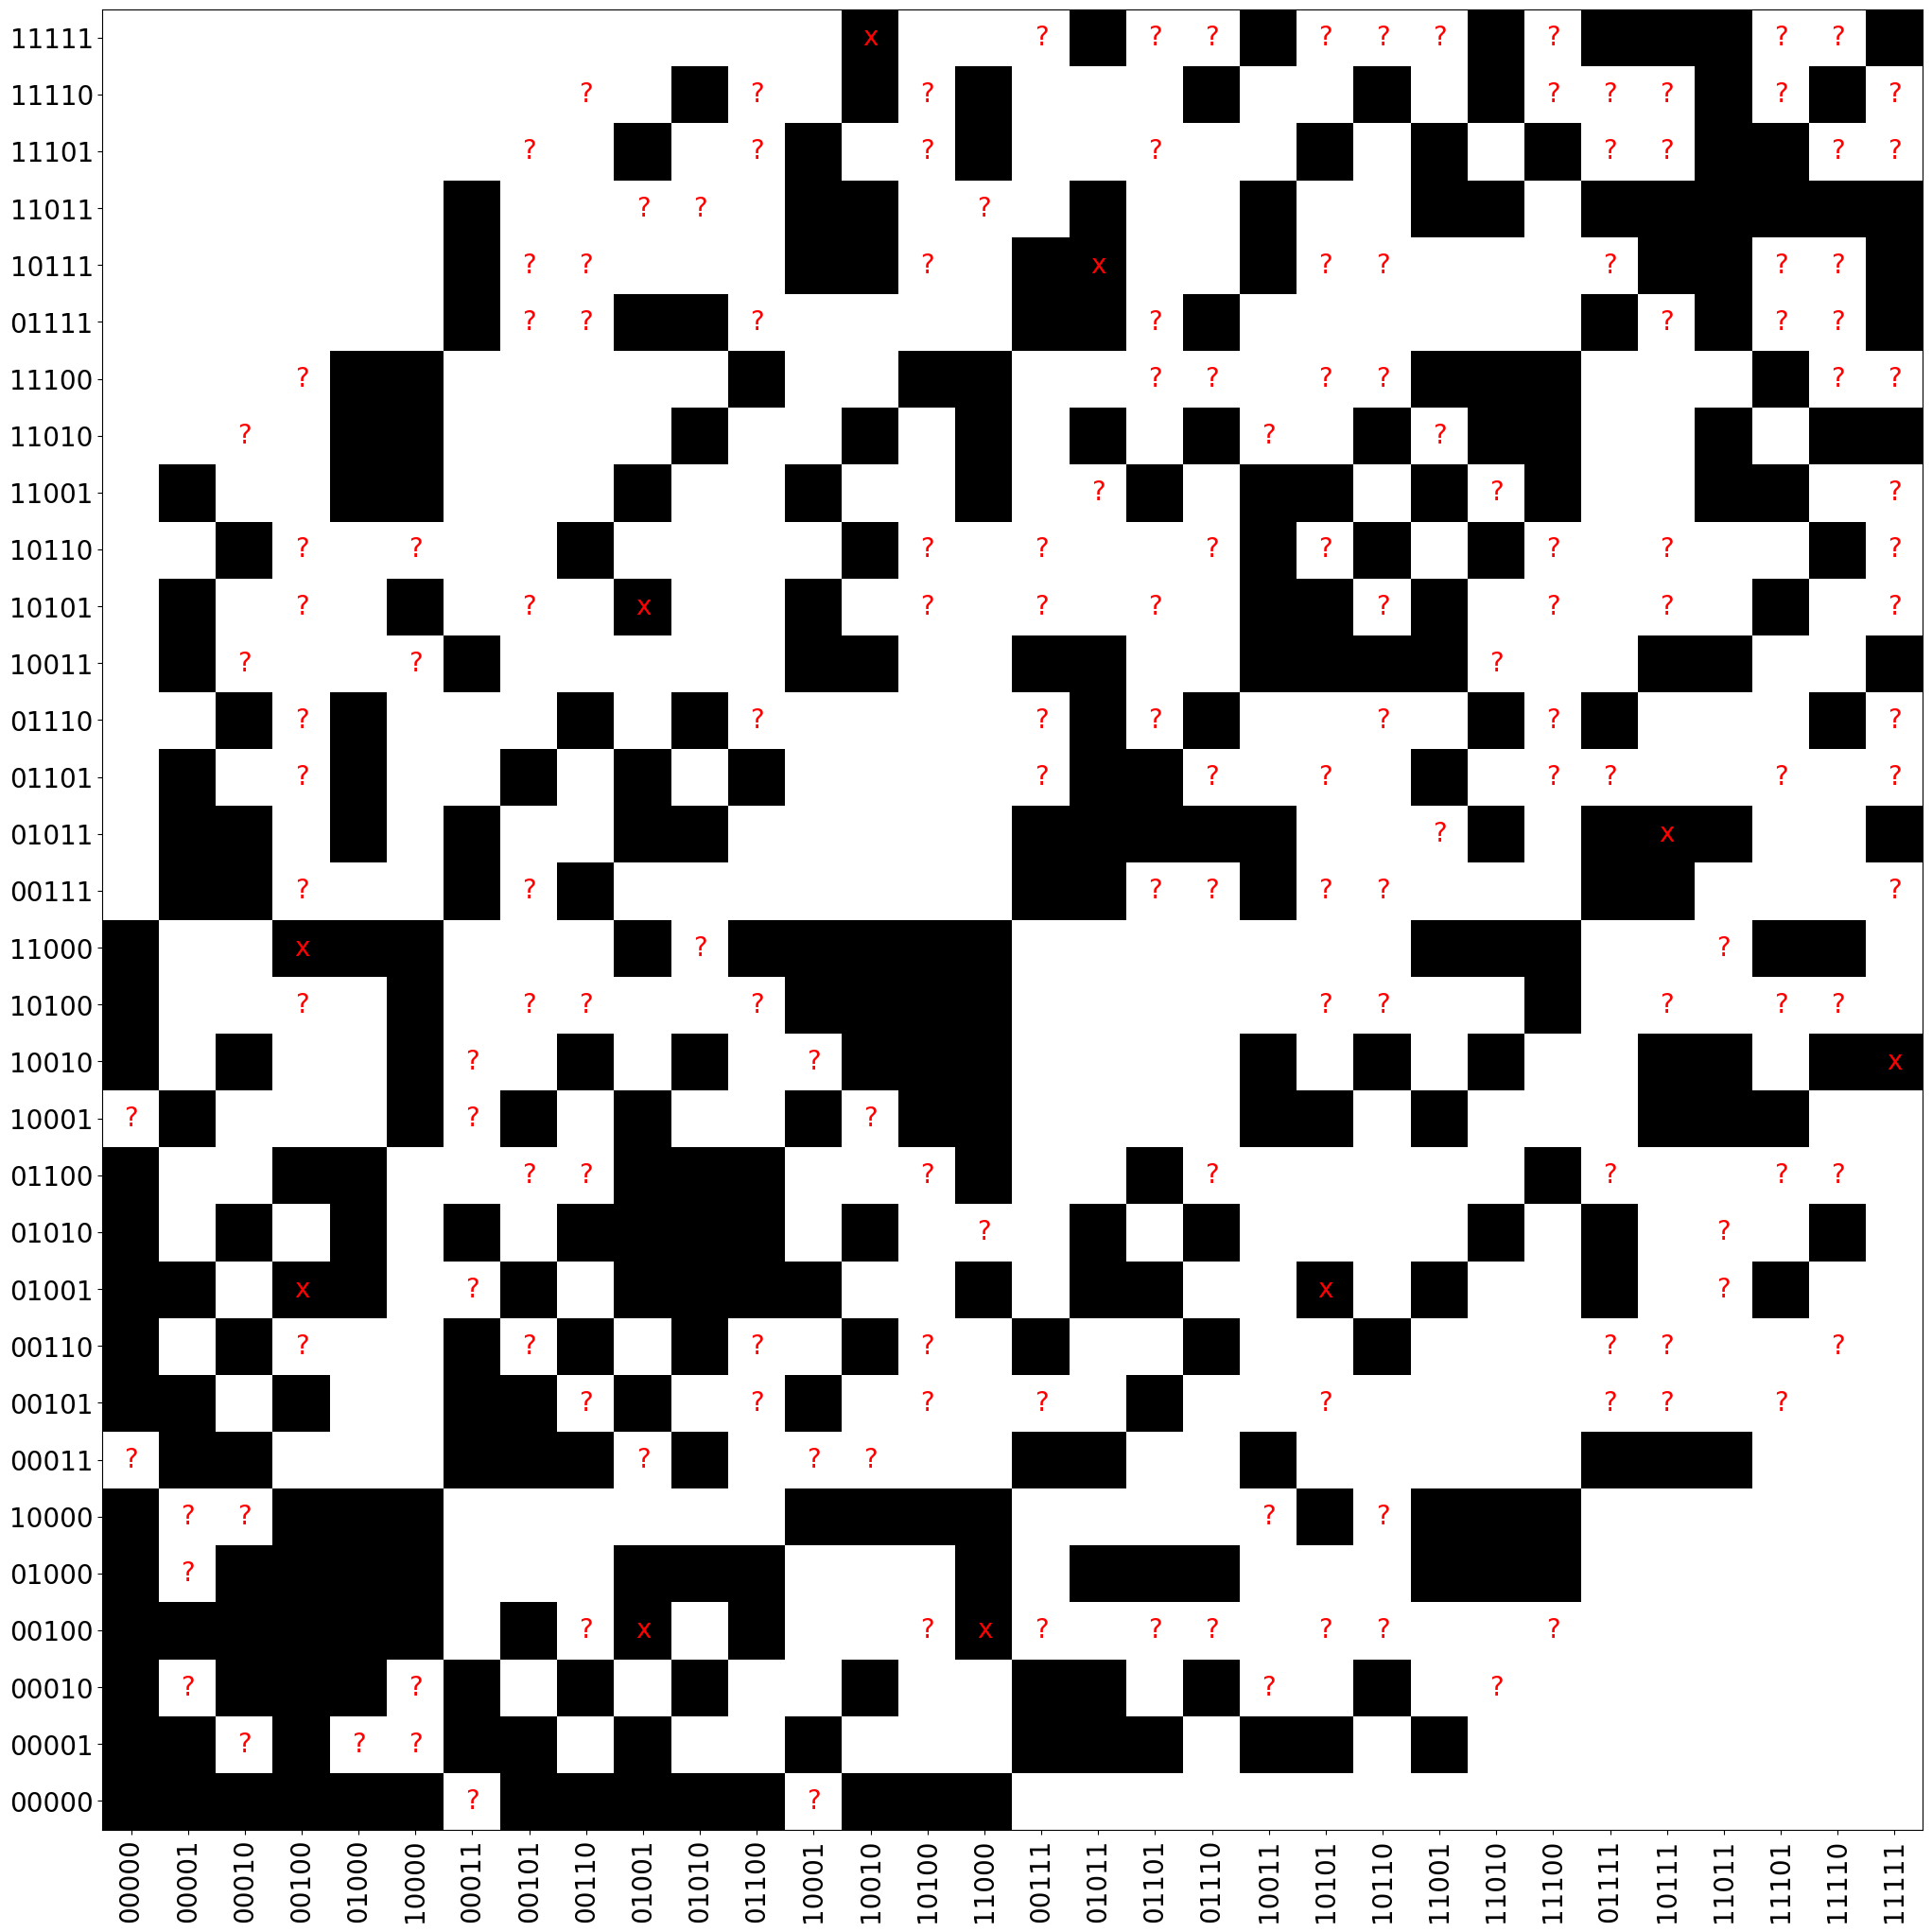

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))

xlabels, ylabels = stringify_state(x), stringify_state(y)
heatmap(ax, ~neighbors, xlabels, ylabels, annotation=errors)
fig.savefig(f"hd_tomography_n{min_qubits_for_data_encoding(x)}.png", bbox_inches="tight")